# **Проект Мастерской №2 - Выделения пользователей для совершения покупки** 

**Описание**

Интернет-магазин собирает историю покупателей, проводит рассылки предложений и планирует будущие продажи. Для оптимизации процессов надо выделить пользователей, которые готовы совершить покупку в ближейшее время.

**Цель**

Предсказать вероятность покупки в течение 90 дней

**Задачи**

* Изучить данные;
* Разработать полезные признаки;
* Создать модель для классификации пользователей;
* Улучшить модель и максимизировать метрику roc_auc;
* Выполнить тестирование.

**Описание данных**

Предоставлены 5 датасетов со следующими данными:

**apparel-purchases.csv**

Данные о покупках клиентов по дням и по товарам. В каждой записи покупка определенного товара, его цена, количество штук. В таблице есть списки идентификаторов, к каким категориям относится товар. Часто это вложенные категории (например автотовары-аксессуары-освежители), но также может
включать в начале списка маркер распродажи или маркер женщинам/мужчинам. Нумерация категорий сквозная для всех уровней, то есть 44 на второй позиции списка или на третьей – это одна и та же категория. Иногда дерево категорий обновляется, поэтому могут меняться вложенности, например ['4', '28', '44', '1594'] или ['4', '44', '1594']. Как обработать такие случаи – можете предлагать свои варианты решения.

- client_id идентификатор клиента
- quantity количество единиц товара
- price цена товара
- category_ids идентификаторы категорий
- date дата покупки
- message_id идентификатор сообщения из рассылки

**apparel-messages.csv**

Рассылки, которые были отправлены клиентам из таблицы покупок.

- bulk_campaign_id идентификатор рассылки
- client_id идентификатор клиента
- message_id идентификатор сообщения
- event действие с сообщением (отправлено, открыто, покупка…)
- channel канал рассылки
- date дата действия
- created_at дата-время полностью

**apparel-target_binary.csv**

- client_id идентификатор клиента
- target клиент совершил покупку в целевом периоде

**full_campaign_daily_event.csv**

Агрегация общей базы рассылок по дням и типам событий
- date дата
- bulk_campaign_id идентификатор рассылки
- count_event* общее количество каждого события event
- nunique_event* количество уникальных client_id в каждом событии

\* в именах колонок найдете все типы событий event

**full_campaign_daily_event_channel.csv**

Агрегация по дням с учетом событий и каналов рассылки
- date дата
- bulk_campaign_id идентификатор рассылки
- count_event*_channel* общее количество каждого события по каналам
- nunique_event*_channel* количество уникальных client_id по событиям и каналам

\* в именах колонок есть все типы событий event и каналов рассылки channel

Для решения задач в первую очередь будем исследовать и агрегировать первые три датасета.

In [1]:
# загрузка библиотек
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import ast

from scipy.stats import loguniform
from phik.report import plot_correlation_matrix
from phik import report

from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import (
    roc_auc_score,
    precision_score,
    recall_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

In [2]:
# постоянные
RANDOM_STATE = 1234
TRAIN_SIZE = 0.8
N_ITER = 30
K_FOLDS = 5

## Загрузка данных

In [3]:
# загрузка датасетов
df_messages = pd.read_csv("./filtered_data/apparel-messages.csv")
df_purchases = pd.read_csv("./filtered_data/apparel-purchases.csv")
df_target = pd.read_csv("./filtered_data/apparel-target_binary.csv")
df_full_campaign_daily_event = pd.read_csv("./filtered_data/full_campaign_daily_event.csv")
df_full_campaign_daily_event_channel = pd.read_csv("./filtered_data/full_campaign_daily_event_channel.csv")

In [4]:
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB


In [5]:
df_purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB


In [6]:
df_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


## Предобработка данных

Выведем типы данных.

In [7]:
df_messages.dtypes

bulk_campaign_id     int64
client_id            int64
message_id          object
event               object
channel             object
date                object
created_at          object
dtype: object

In [8]:
df_messages = df_messages.convert_dtypes()
df_messages['date'] = pd.to_datetime(df_messages['date'])
df_messages['created_at'] = pd.to_datetime(df_messages['created_at'])
df_messages.dtypes

bulk_campaign_id             Int64
client_id                    Int64
message_id          string[python]
event               string[python]
channel             string[python]
date                datetime64[ns]
created_at          datetime64[ns]
dtype: object

In [9]:
df_messages.head()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


In [10]:
df_purchases = df_purchases.convert_dtypes()
df_purchases['date'] = pd.to_datetime(df_purchases['date'])
df_purchases.dtypes

client_id                Int64
quantity                 Int64
price                    Int64
category_ids    string[python]
date            datetime64[ns]
message_id      string[python]
dtype: object

In [11]:
df_purchases.head()

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


In [12]:
df_target.dtypes

client_id    int64
target       int64
dtype: object

In [13]:
df_target.head()

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


In [14]:
df_messages.isnull().sum() / df_messages.shape[0] * 100.00

bulk_campaign_id    0.0
client_id           0.0
message_id          0.0
event               0.0
channel             0.0
date                0.0
created_at          0.0
dtype: float64

In [15]:
df_purchases.isnull().sum() / df_purchases.shape[0] * 100.00

client_id       0.0
quantity        0.0
price           0.0
category_ids    0.0
date            0.0
message_id      0.0
dtype: float64

In [16]:
df_target.isnull().sum() / df_target.shape[0] * 100.00

client_id    0.0
target       0.0
dtype: float64

Пропущенных значений нет во всех трёх датасетах. Теперь посмотрим дубликаты.

In [17]:
df_messages.duplicated().sum()

48610

В датасете df_messages есть столбец created_at (дата-время), поэтому дубликатов тут быть не должно. Удаляем. 

In [18]:
df_messages = df_messages.drop_duplicates()
df_messages.duplicated().sum()

0

In [19]:
df_purchases.duplicated().sum()

73020

Т.к. тут есть столбец с датой (без времени покупки), так что вполне возможно, что в один день потребитель может покупать несколько раз один и тот же товар. Не удаляем.

В датасете category_ids списки идентификаторов категорий товаров. Сохраним первую и последнюю категорию: первую - для того, чтобы укрупненно сохранить информацию о категориях товаров, последнюю - сохранить эту информацию более детально (возможно мы ей не воспользуемся, если идентификаторов будет слишком много).

In [20]:
# перевод строкового типа в списки
df_purchases['category_ids'] = df_purchases['category_ids'].apply(ast.literal_eval)

# функции для возвращения первого и последнего идентификатора (в противном случае NaN)
def first_cat(lst):
    return lst[0] if lst else None

def last_cat(lst):
    return lst[-1] if lst else None

# создание новых категорий
df_purchases['first_category'] = df_purchases['category_ids'].apply(first_cat)
df_purchases['last_category']  = df_purchases['category_ids'].apply(last_cat)

In [21]:
df_purchases.head()

,client_id,quantity,price,category_ids,date,message_id,first_category,last_category
0,1515915625468169594,1,1999,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d,4,431
1,1515915625468169594,1,2499,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d,4,431
2,1515915625471138230,1,6499,"[4, 28, 57, 431]",2022-05-16,1515915625471138230-4437-6282242f27843,4,431
3,1515915625471138230,1,4999,"[4, 28, 244, 432]",2022-05-16,1515915625471138230-4437-6282242f27843,4,432
4,1515915625471138230,1,4999,"[4, 28, 49, 413]",2022-05-16,1515915625471138230-4437-6282242f27843,4,413


In [22]:
list(df_purchases['first_category'].sort_values().unique())

['1', '2', '3', '4', '5', '5562', '5963', '6060', None]

In [23]:
len(list(df_purchases['first_category'].sort_values().unique()))

9

In [24]:
len(list(df_purchases['last_category'].sort_values().unique()))

843

In [25]:
min(list(df_purchases['date'].sort_values().unique()))

Timestamp('2022-05-16 00:00:00')

In [26]:
max(list(df_purchases['date'].sort_values().unique()))

Timestamp('2024-02-16 00:00:00')

Самая ранняя покупка в датасете совершена в мае 2022 года, поздняя - в феврале 2024 года.

In [27]:
list(df_messages['event'].sort_values().unique())

['click',
 'close',
 'complain',
 'hard_bounce',
 'hbq_spam',
 'open',
 'purchase',
 'send',
 'soft_bounce',
 'subscribe',
 'unsubscribe']

In [28]:
list(df_messages['channel'].sort_values().unique())

['email', 'mobile_push']

In [29]:
min(list(df_messages['date'].sort_values().unique()))

Timestamp('2022-05-19 00:00:00')

In [30]:
max(list(df_messages['date'].sort_values().unique()))

Timestamp('2024-02-15 00:00:00')

Даты датасете df_messages в похожем диапазоне, что и в датасете df_purchases.

## Исследовательский анализ данных

In [31]:
# напишем функцию, которая будет выводить столбчатые диаграммы для анализа численности по категориям
def categorical_feature_plot(dataset, category):
    df_category = dataset.pivot_table(index=category, values='client_id', aggfunc='count')
    df_category.columns=['Число клиентов']
    df_category.plot(y='Число клиентов', kind ='bar')
    title = "Распределение клиентов по признаку " + category
    plt.title(title)
    plt.xlabel(category)
    plt.ylabel('Число клиентов')
    plt.show()
    df_category_total = df_category['Число клиентов'].sum()
    df_category['Доля клиентов'] = round(df_category['Число клиентов']/df_category_total*100, 2)
    print(df_category)

# напишем функцию, которая будет выводить гистограмму и ящик с усами для количественного признака
def quantitative_feature_plot(dataset, feature):
    dataset[feature].hist(bins=20)
    plt.title(feature)
    plt.xlabel(feature)
    plt.ylabel('Quantity')
    plt.show()
    plt.figure(figsize=(25, 10))
    (sns.boxplot(data = dataset, y = feature, showfliers=True, showmeans=True)
    .set(ylabel = feature))
    plt.show()
    print(dataset[feature].describe())
    
def quantitative_discr_feature_plot(dataset, feature):
    df_category = dataset.pivot_table(index=feature, values='client_id', aggfunc='count')
    df_category.columns=['Число клиентов']
    df_category.plot(y='Число клиентов', kind ='bar', figsize=(40, 6))
    plt.title(feature)
    plt.xlabel(feature)
    plt.ylabel('Quantity')
    plt.show()
    plt.figure(figsize=(40, 10))
    (sns.boxplot(data = dataset, y = feature, showfliers=True, showmeans=True)
    .set(ylabel = feature))
    plt.show()
    print(dataset[feature].describe())

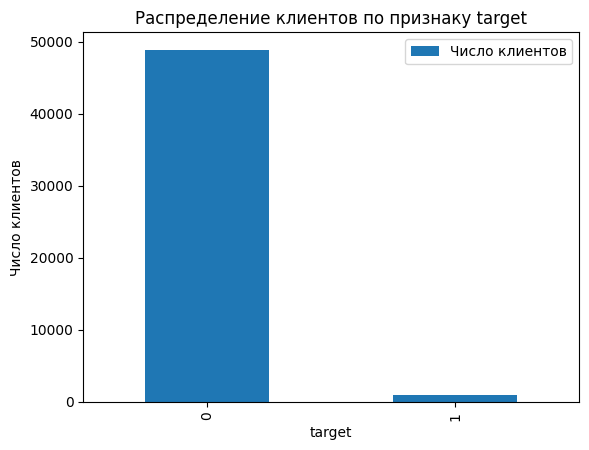

        Число клиентов  Доля клиентов
target                               
0                48888          98.07
1                  961           1.93


In [32]:
categorical_feature_plot(df_target, 'target')

У нас датасет с несбалансированным целевым признаком.

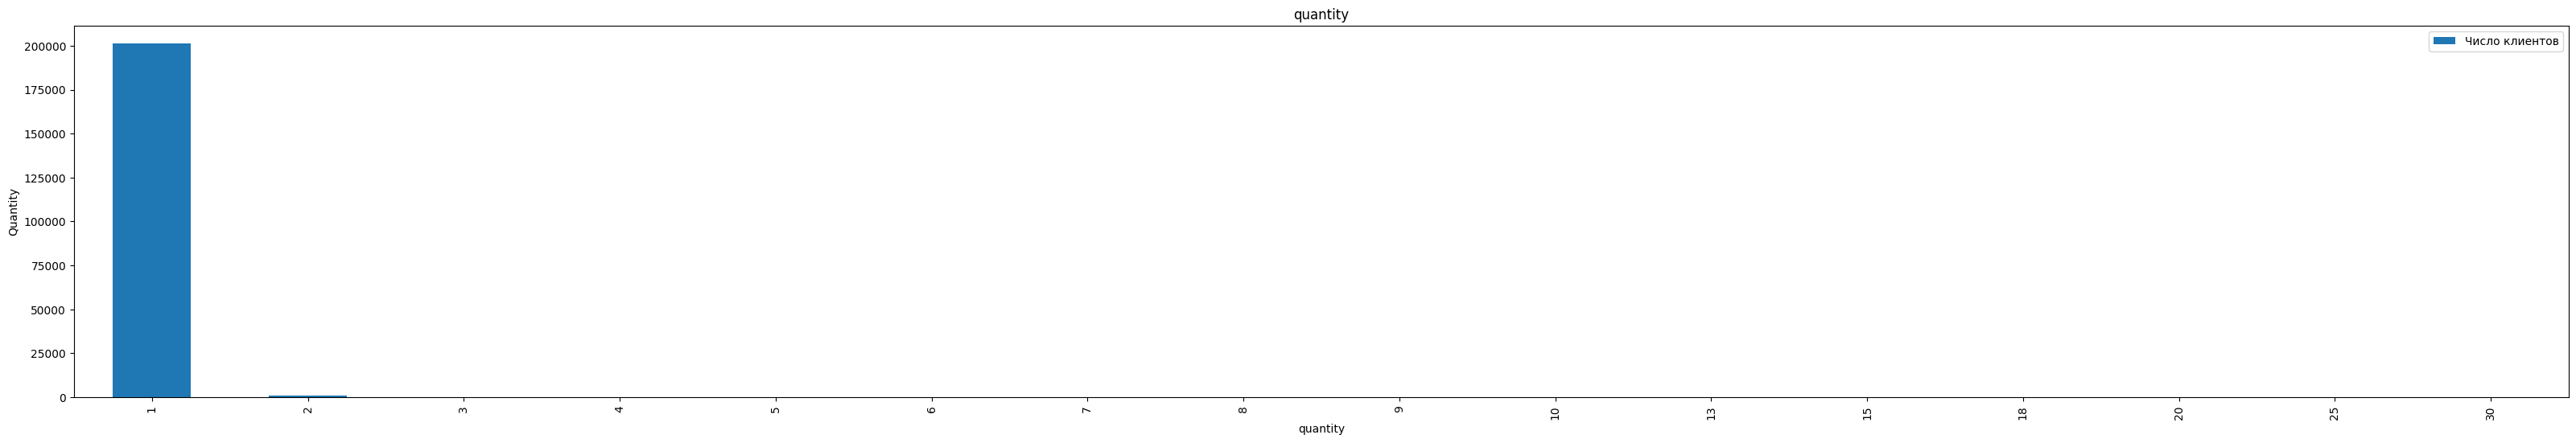

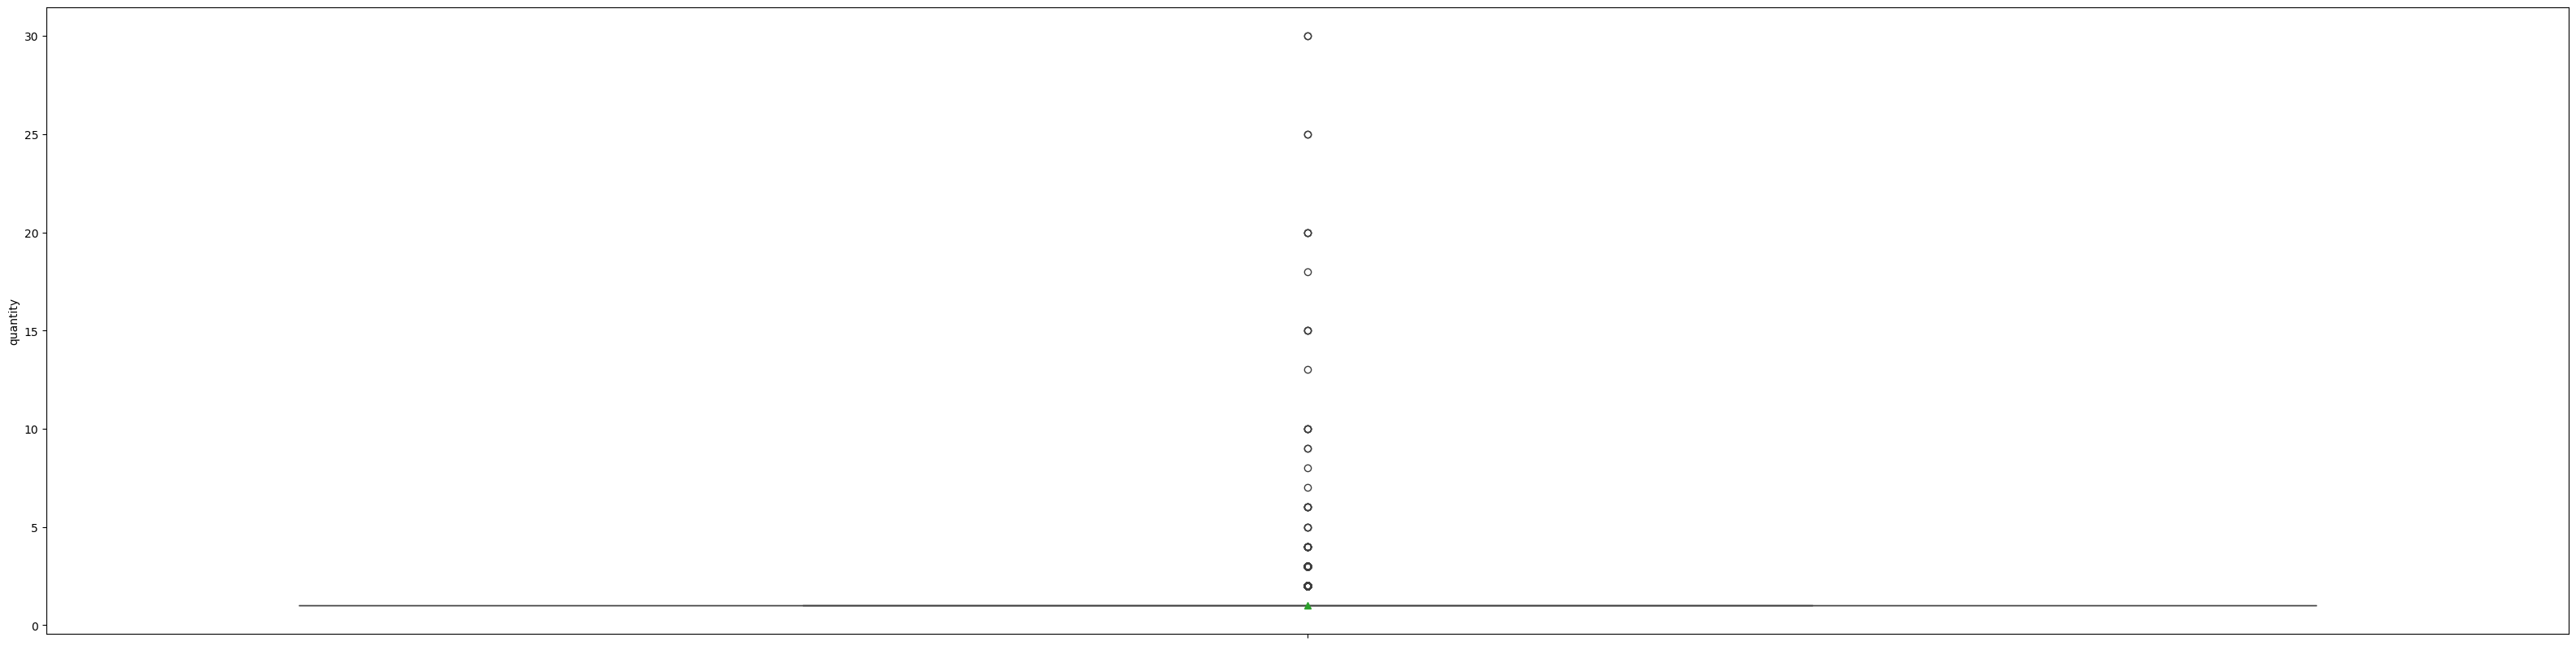

count    202208.0
mean     1.006483
std      0.184384
min           1.0
25%           1.0
50%           1.0
75%           1.0
max          30.0
Name: quantity, dtype: Float64


In [33]:
quantitative_discr_feature_plot(df_purchases, 'quantity')

Подавляющее большинство покупок - по одной штуке.

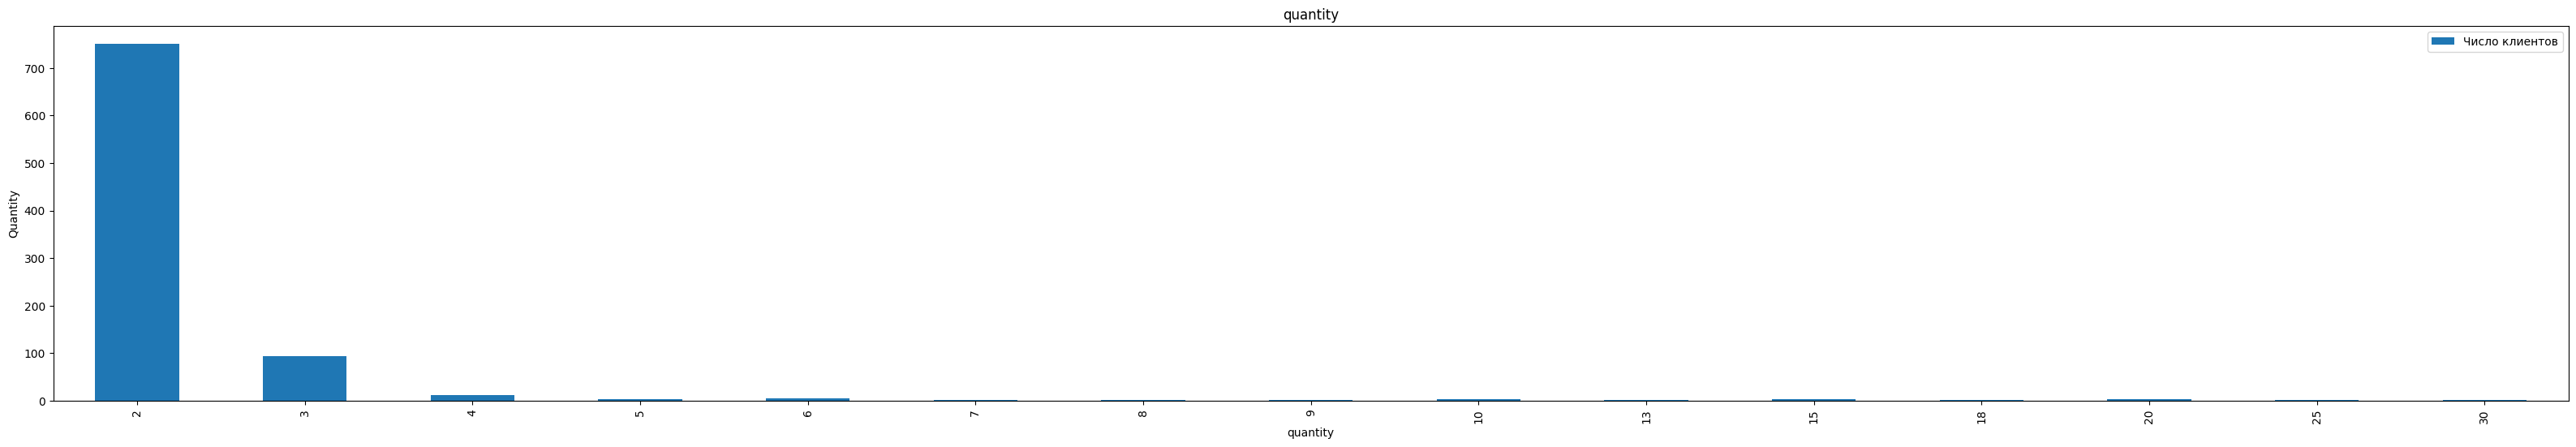

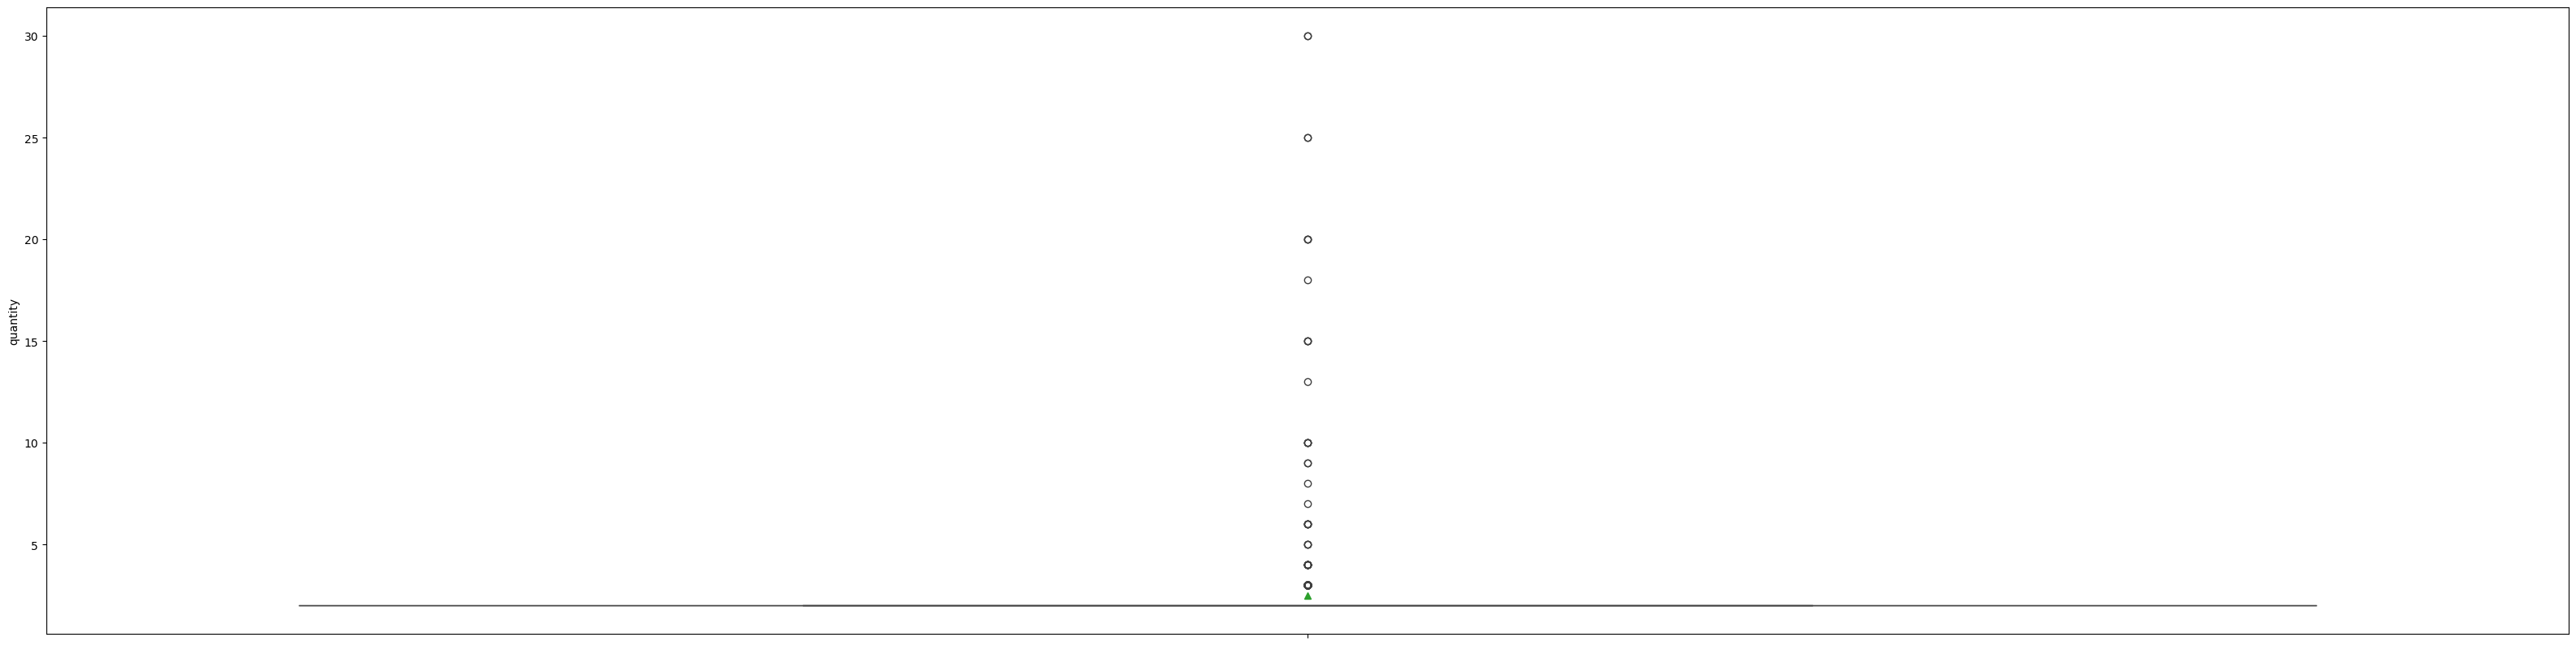

count       885.0
mean     2.481356
std       2.36417
min           2.0
25%           2.0
50%           2.0
75%           2.0
max          30.0
Name: quantity, dtype: Float64


In [34]:
quantitative_discr_feature_plot(df_purchases[df_purchases['quantity'] > 1], 'quantity')

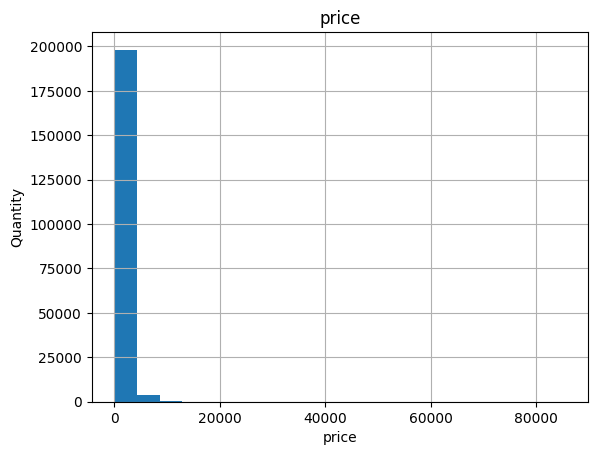

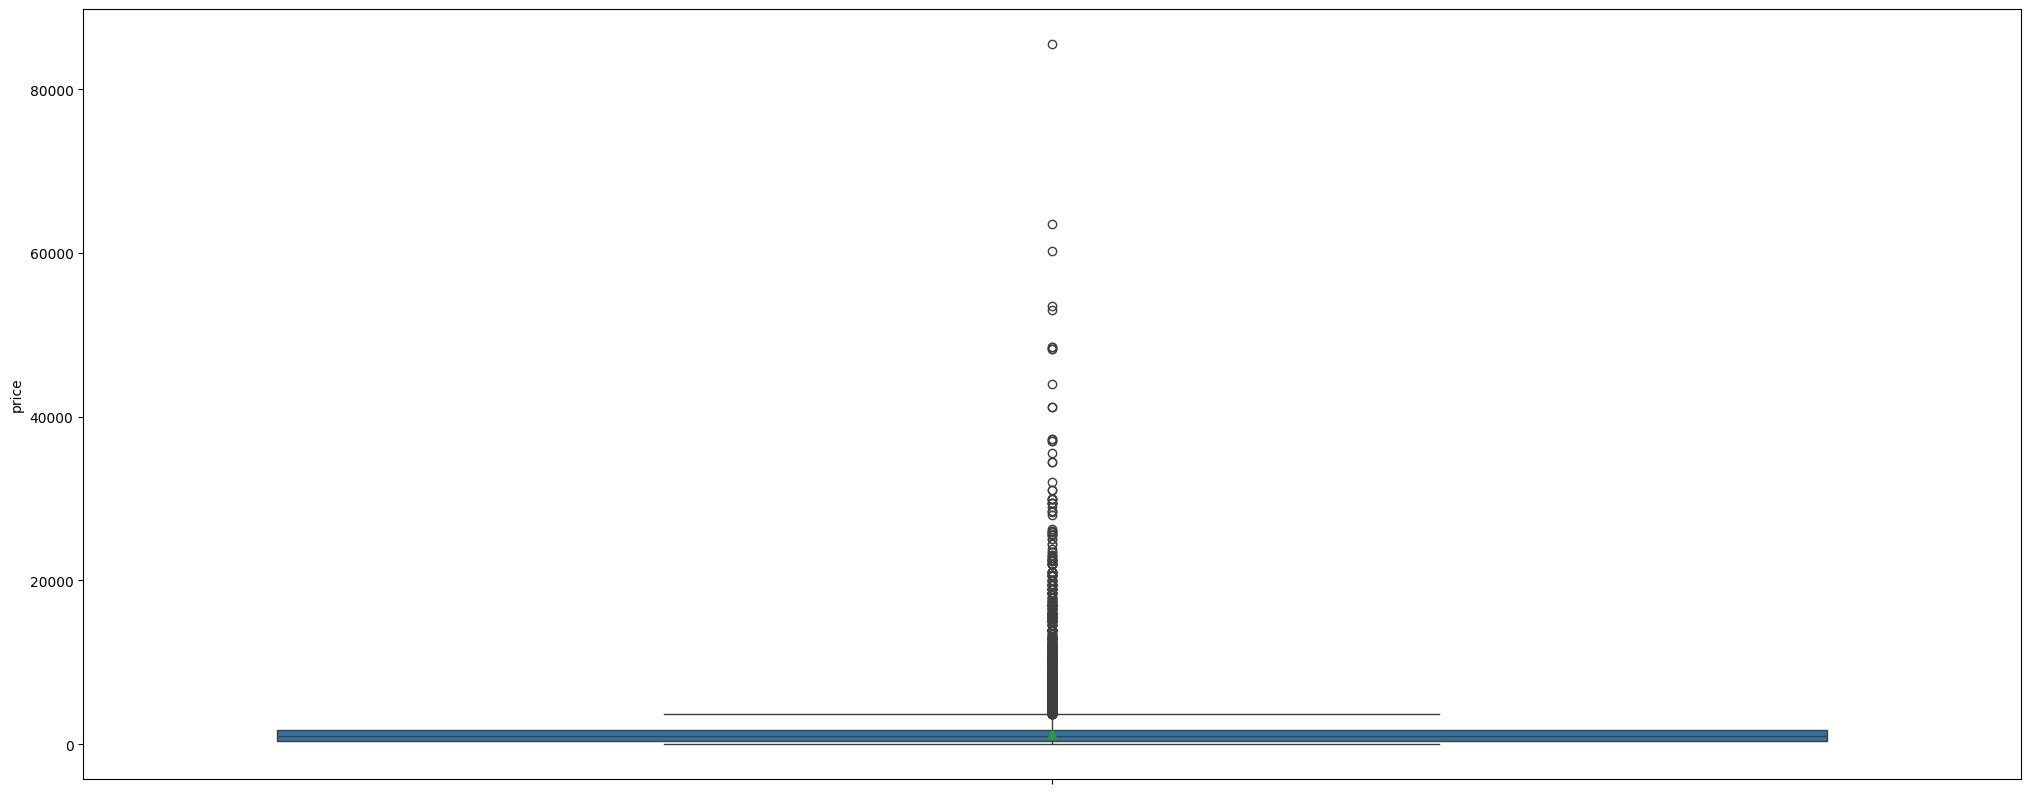

count       202208.0
mean     1193.301516
std      1342.252664
min              1.0
25%            352.0
50%            987.0
75%           1699.0
max          85499.0
Name: price, dtype: Float64


In [35]:
quantitative_feature_plot(df_purchases, 'price')

Большинство покупок по - в районе 1200 рублей, максимальная цена покупки - ~85 тыс. рублей.

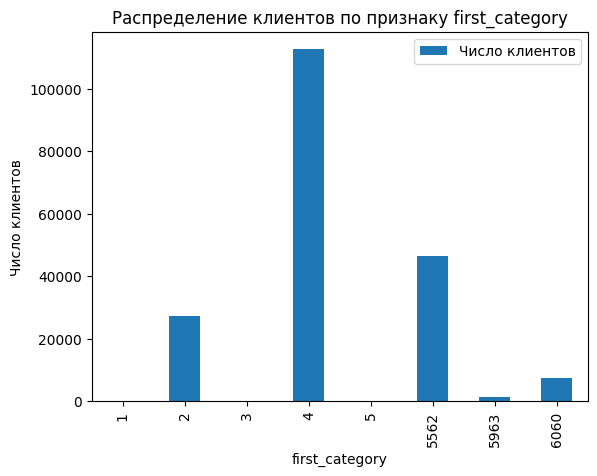

                Число клиентов  Доля клиентов
first_category                               
1                            3            0.0
2                        27429          14.04
3                           11           0.01
4                       112578          57.62
5                            2            0.0
5562                     46511          23.81
5963                      1272           0.65
6060                      7559           3.87


In [36]:
categorical_feature_plot(df_purchases, 'first_category')

Почти 60 процентов покупок относятся к категории 4. Много покупок категорий 5562 и 2.

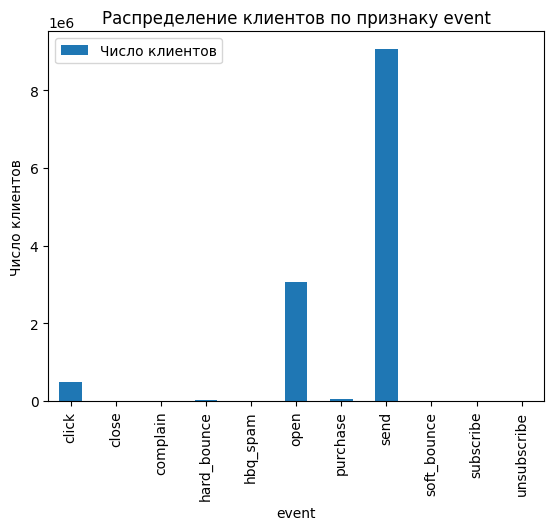

             Число клиентов  Доля клиентов
event                                     
click                483326           3.81
close                     1            0.0
complain                527            0.0
hard_bounce           19763           0.16
hbq_spam                823           0.01
open                3052481          24.05
purchase              62593           0.49
send                9058174          71.37
soft_bounce           10582           0.08
subscribe                85            0.0
unsubscribe            2833           0.02


In [37]:
categorical_feature_plot(df_messages, 'event')

В основном клиенты (~70 процентов) не открывают сообщения :) открывают около 25 процентов. Непонятно в чём разница click и open?

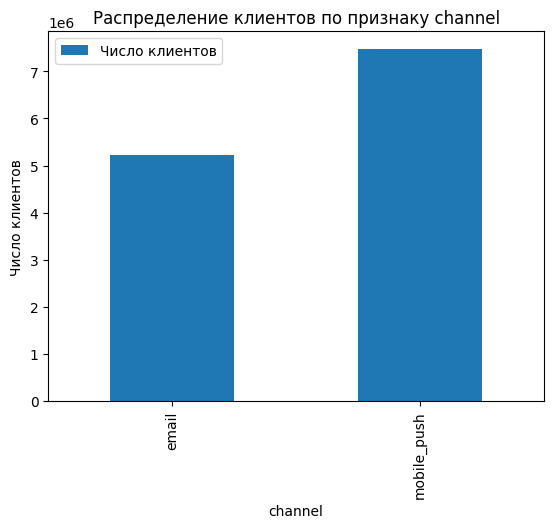

             Число клиентов  Доля клиентов
channel                                   
email               5220716          41.14
mobile_push         7470472          58.86


In [38]:
categorical_feature_plot(df_messages, 'channel')

## Подготовка данных

### Создание признаков

Таким образом, у нас распоряжении 2 датасета с данными за неполные 2 года (с мая 2022 по февраль 2024 года). Подготовим признаки с помощью агрегированных таблиц и будем присоединять к df_target.

Начнём с признаков, которые можем получить с датасета df_purchases.

- *Общая сумма, которую клиент израсходовал за период*

In [39]:
df_purchases['total_sum'] = df_purchases['price'] * df_purchases['quantity']
pivot_total_sum = df_purchases.pivot_table(
    index='client_id',
    values='total_sum',      
    aggfunc='sum',
    fill_value=0
).reset_index()
pivot_total_sum.head()

,client_id,total_sum
0,1515915625468060902,6993
1,1515915625468061003,16235
2,1515915625468061099,299
3,1515915625468061100,2098
4,1515915625468061170,33601


In [40]:
# присоединяем
df_final = df_target.merge(pivot_total_sum, how='left', on='client_id')

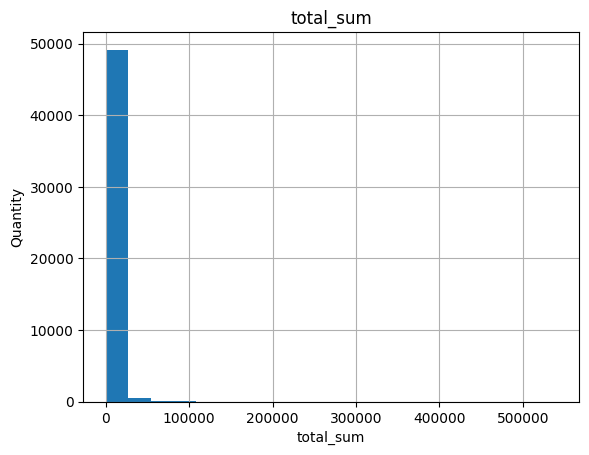

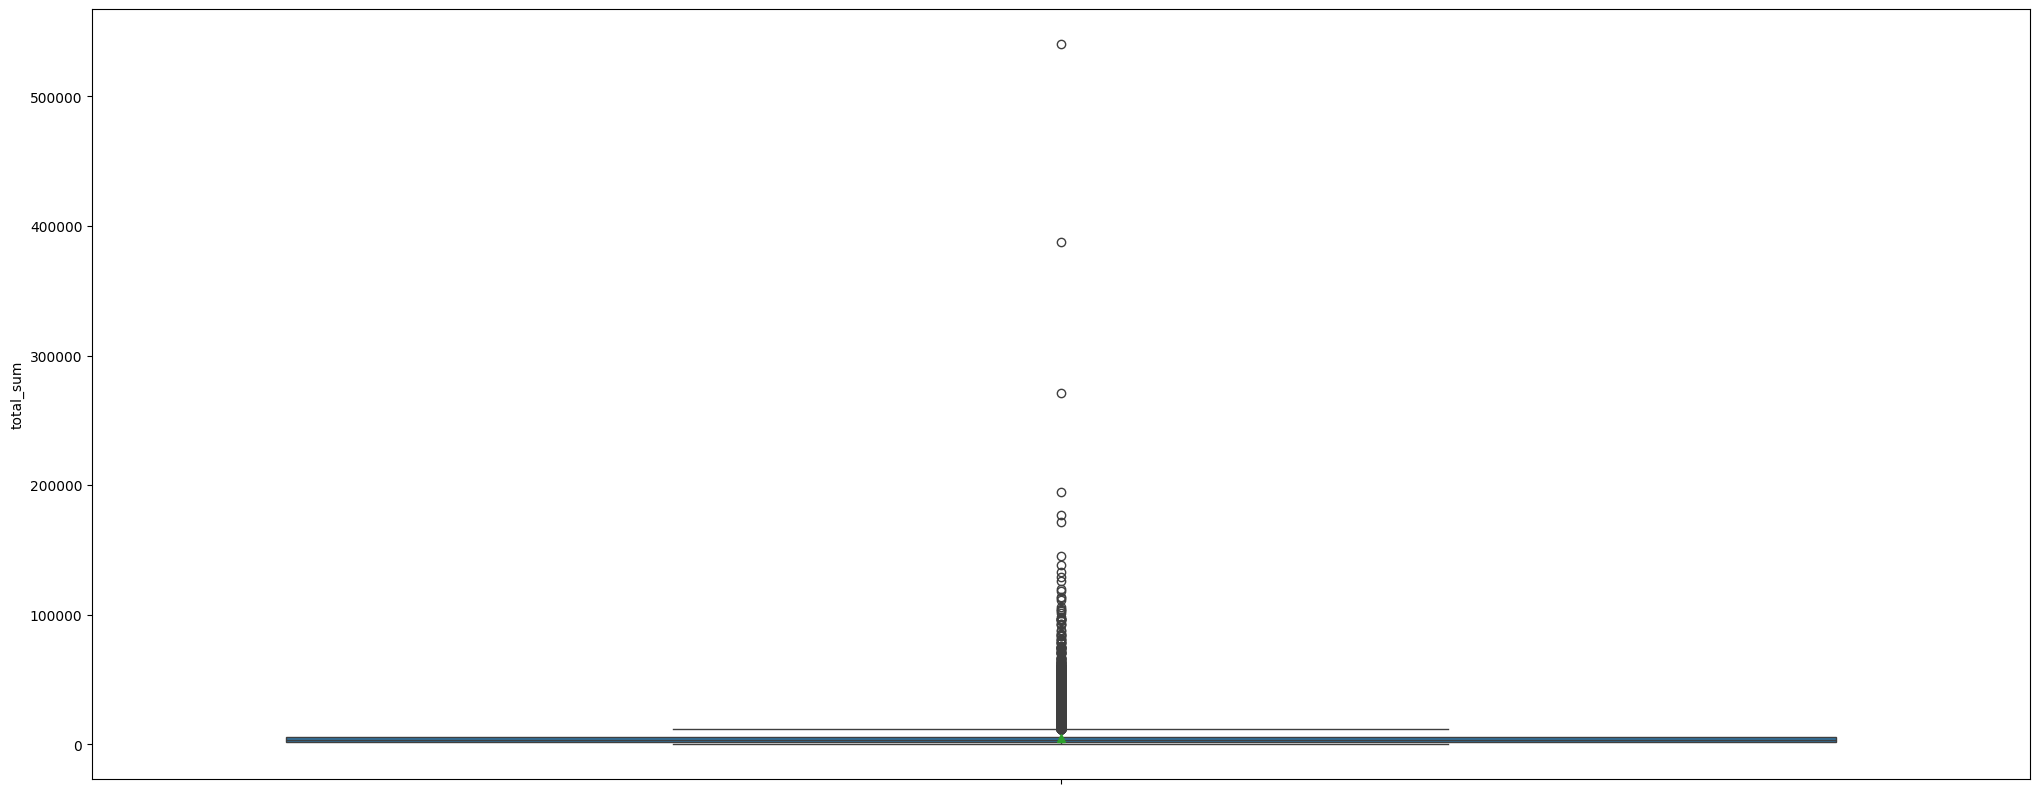

count        49849.0
mean     4865.584264
std      7351.467229
min              1.0
25%           1499.0
50%           2969.0
75%           5698.0
max         540408.0
Name: total_sum, dtype: Float64


In [41]:
quantitative_feature_plot(df_final, 'total_sum')

Получился скошенный график. Попробуем применить логарифмирование, чтобы это устранить.

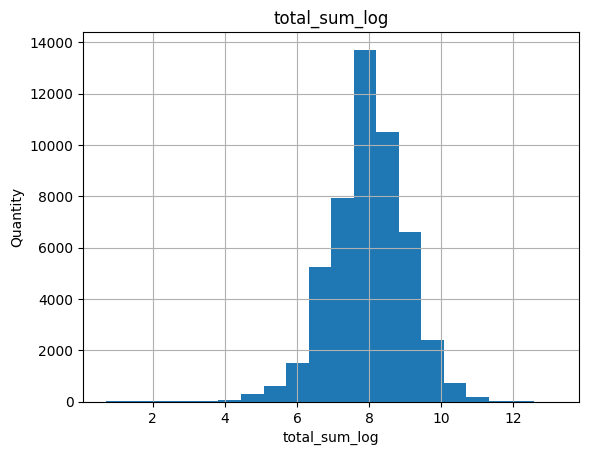

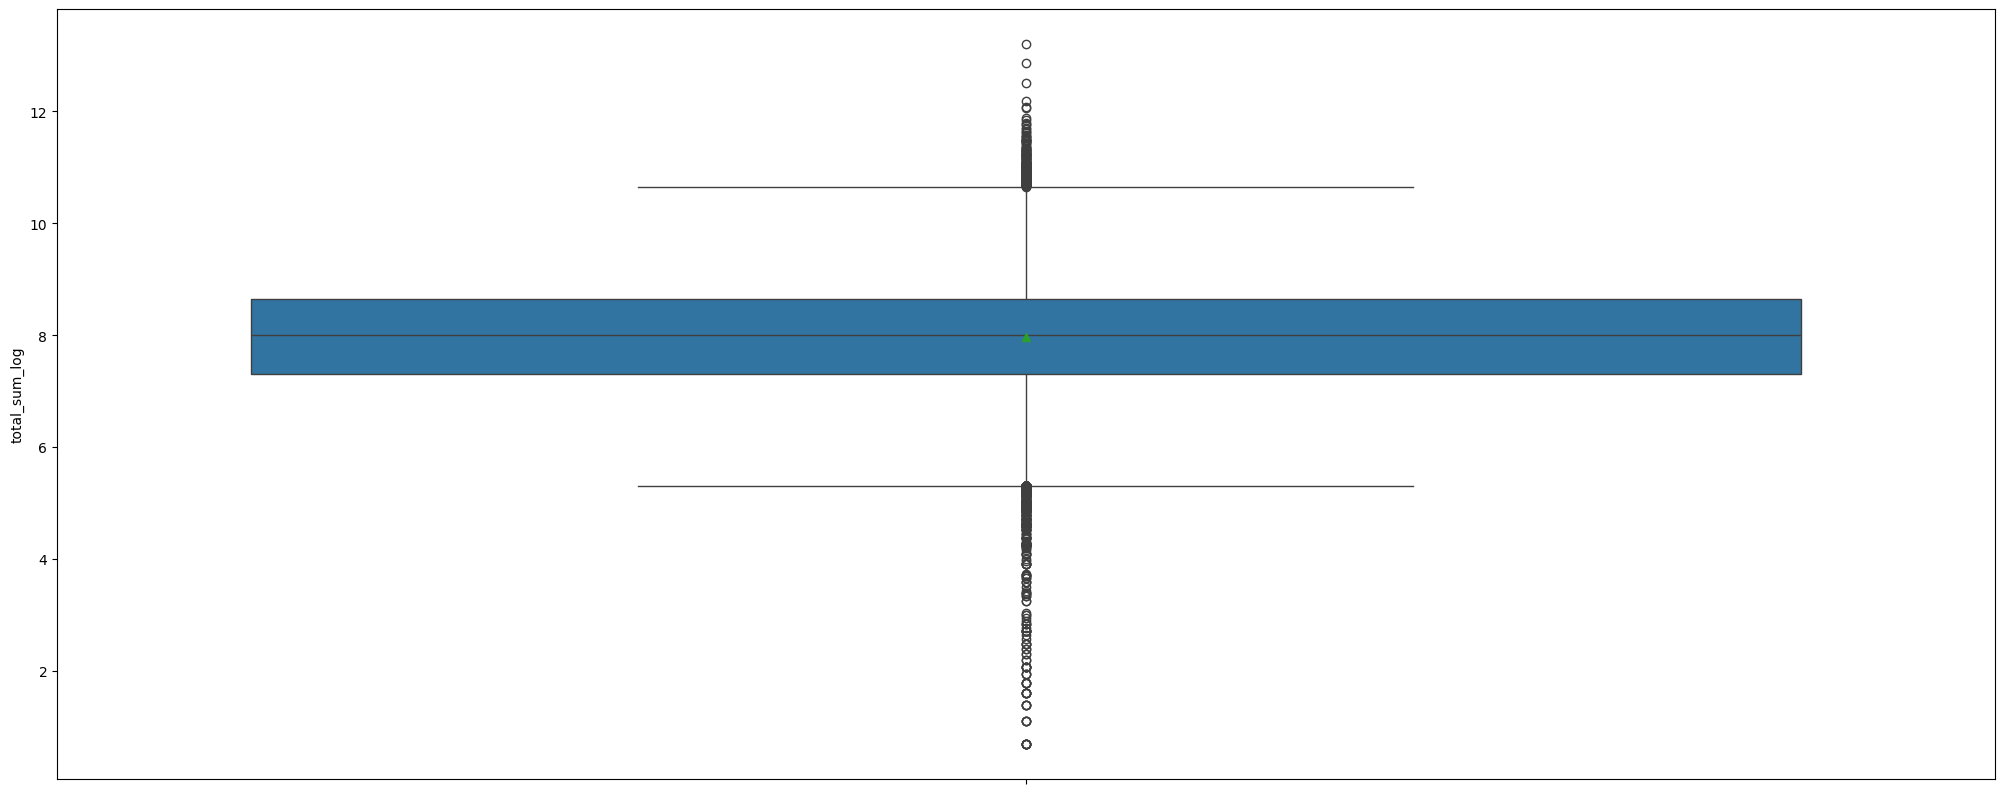

count      49849.0
mean      7.970241
std        1.04411
min       0.693147
25%        7.31322
50%       7.996317
75%       8.648046
max      13.200082
Name: total_sum_log, dtype: Float64


In [42]:
df_final['total_sum_log'] = np.log1p(df_final['total_sum'])
quantitative_feature_plot(df_final, 'total_sum_log')

- *Общее количество покупок на каждого клиента*

In [43]:
pivot_total_quantity = (
    df_purchases
      .pivot_table(
          index='client_id',
          values='quantity',
          aggfunc='count',
          fill_value=0
      )
      .reset_index()
      .rename(columns={'quantity': 'total_purchases'})
)
df_final = df_final.merge(pivot_total_quantity, how='left', on='client_id')

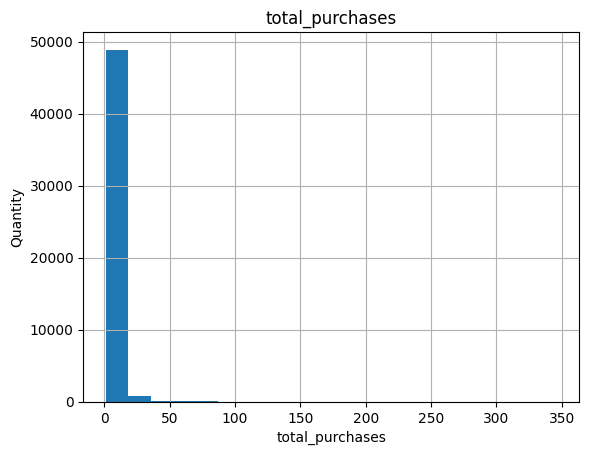

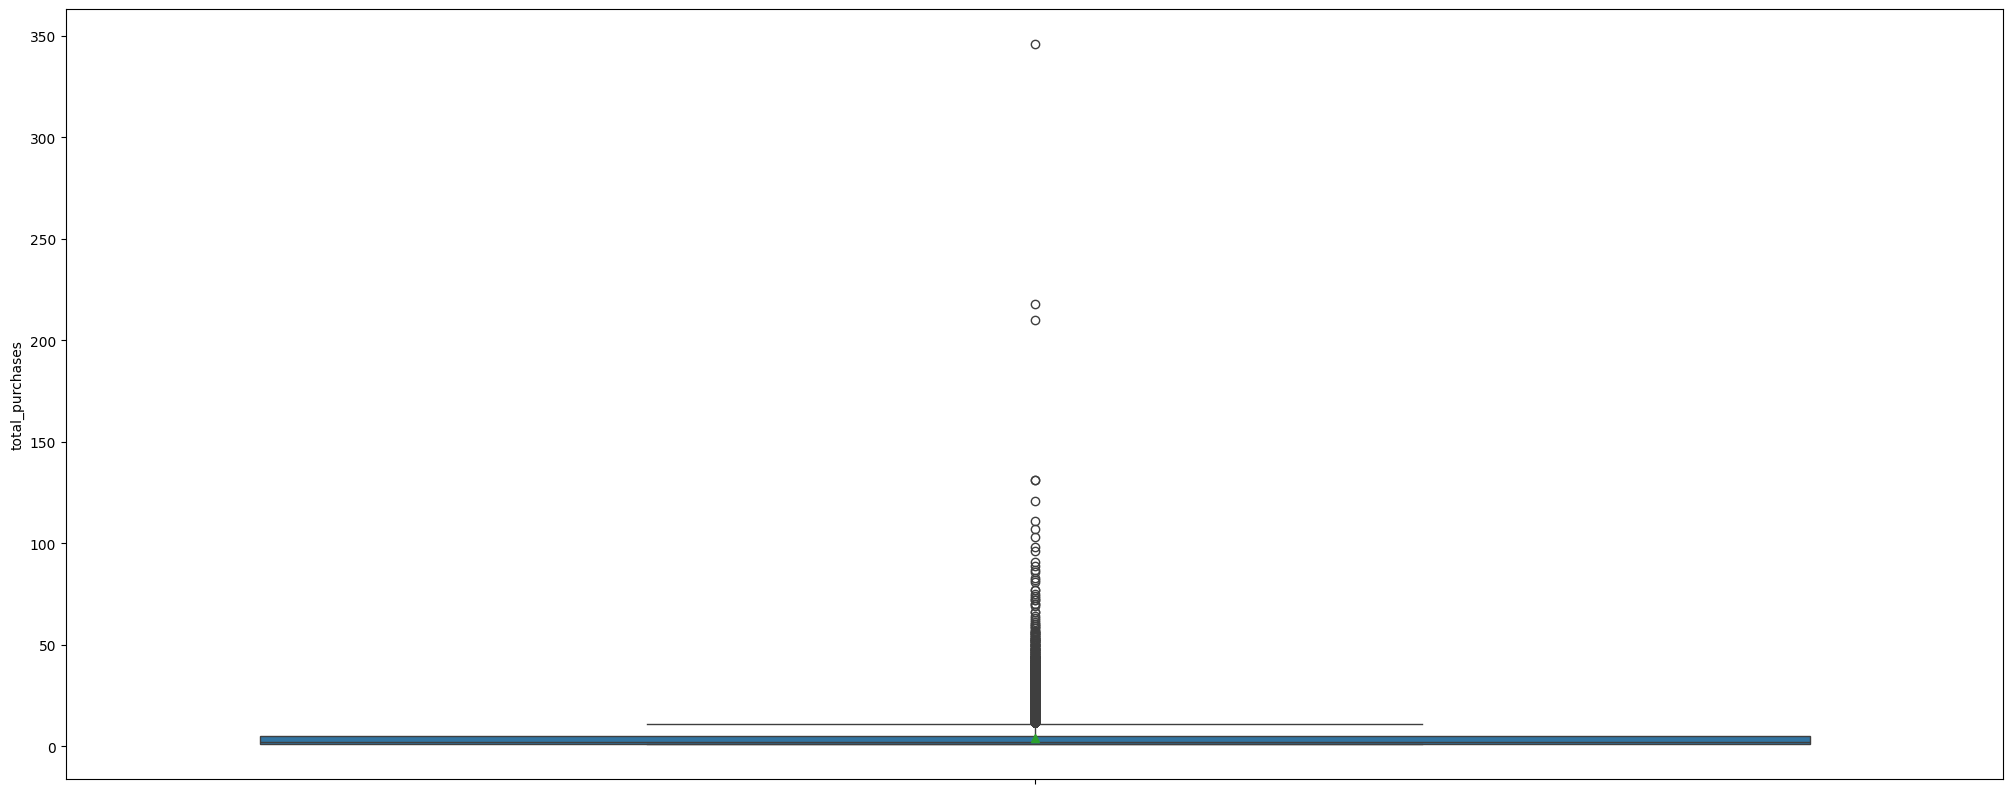

count     49849.0
mean      4.05641
std      5.521669
min           1.0
25%           1.0
50%           2.0
75%           5.0
max         346.0
Name: total_purchases, dtype: Float64


In [44]:
quantitative_feature_plot(df_final, 'total_purchases')

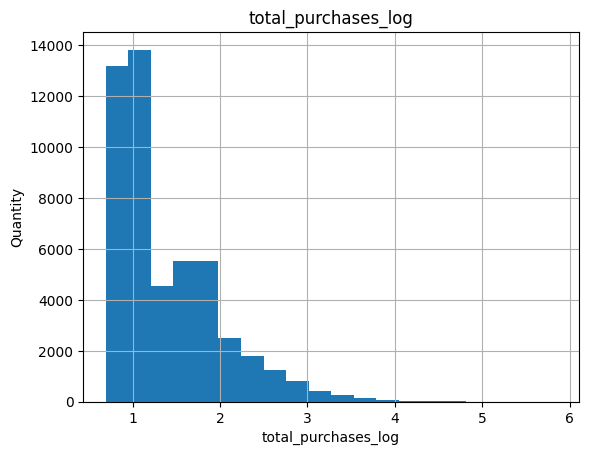

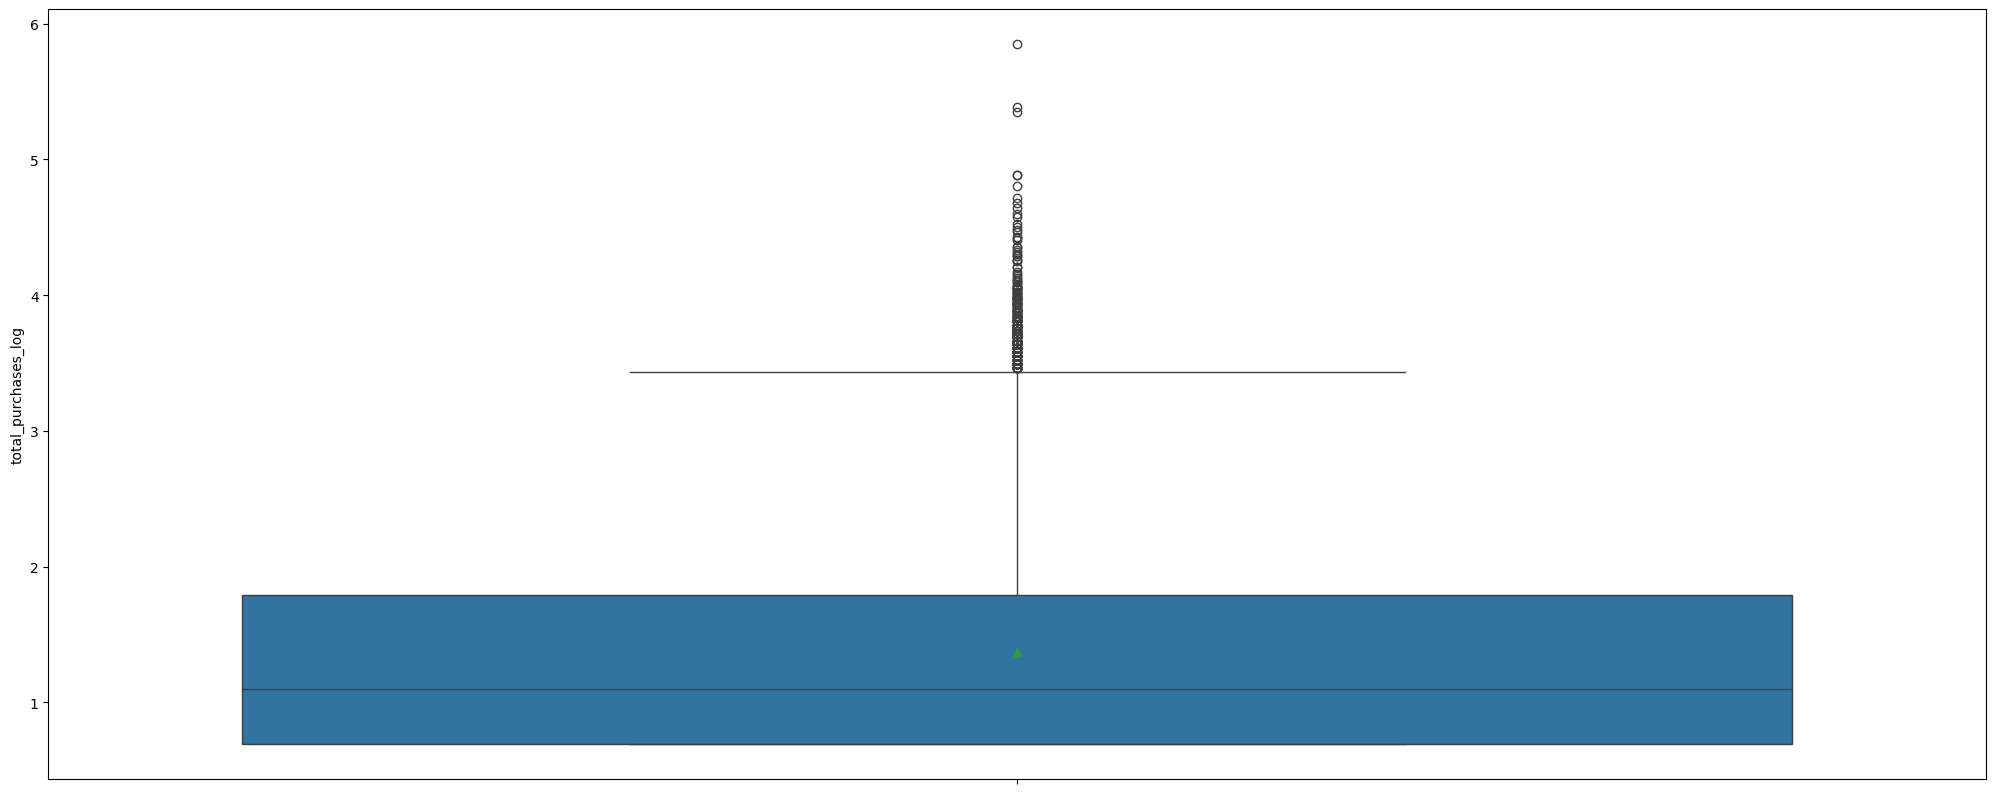

count     49849.0
mean     1.370124
std      0.632019
min      0.693147
25%      0.693147
50%      1.098612
75%      1.791759
max      5.849325
Name: total_purchases_log, dtype: Float64


In [45]:
df_final['total_purchases_log'] = np.log1p(df_final['total_purchases'])
quantitative_feature_plot(df_final, 'total_purchases_log')

- *Общее количество единиц, купленной каждой из категорий*

Возьмём первую из категорий, т.к. категорий в последней многовато.

In [46]:
pivot_categories = df_purchases.pivot_table(
    index='client_id',
    columns='first_category',
    values='quantity',      
    aggfunc='sum',
    fill_value=0
).reset_index()

df_final = df_final.merge(pivot_categories, how='left', on='client_id')
df_final.head()

,client_id,target,total_sum,total_sum_log,total_purchases,total_purchases_log,1,2,3,4,5,5562,5963,6060
0,1515915625468060902,0,6993,8.852808,7,2.079442,0,0,0,7,0,0,0,0
1,1515915625468061003,1,16235,9.694986,7,2.079442,0,0,0,7,0,0,0,0
2,1515915625468061099,0,299,5.703782,1,0.693147,0,0,0,1,0,0,0,0
3,1515915625468061100,0,2098,7.649216,2,1.098612,0,0,0,2,0,0,0,0
4,1515915625468061170,0,33601,10.422341,19,2.995732,0,2,0,15,0,0,0,0


В таком виде у нас может образоваться мультиколлинеарность. Попробуем избавиться от неё тем, что поделим значения в столбцах с числом покупок по категориям на общее число покупок - так мы сохраним информацию о том товары какой категории предполчитал покупать клиент на площадке. 

In [47]:
columns_to_divide = ['1', '2', '3', '4', '5', '5562', '5963', '6060']
df_final[columns_to_divide] = df_final[columns_to_divide].div(df_final['total_purchases'], axis=0)
df_final.head()

,client_id,target,total_sum,total_sum_log,total_purchases,total_purchases_log,1,2,3,4,5,5562,5963,6060
0,1515915625468060902,0,6993,8.852808,7,2.079442,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1515915625468061003,1,16235,9.694986,7,2.079442,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1515915625468061099,0,299,5.703782,1,0.693147,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1515915625468061100,0,2098,7.649216,2,1.098612,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1515915625468061170,0,33601,10.422341,19,2.995732,0.0,0.105263,0.0,0.789474,0.0,0.0,0.0,0.0


- *Число дней с последней покупки*

Последняя дата, доступная в датасете с покупками, - 2024-02-16. Предположим, что выгрузку сделали на следующий день после этой даты. 

In [48]:
last_day = pd.to_datetime('2024-02-17')

# датафрейм с последней датой покупки по всем клиентам
last = (
    df_purchases
    .groupby('client_id', as_index=False)['date']
    .max()
    .rename(columns={'date':'last_purchase_date'})
)
last['days_since_last_purchase'] = (last_day - last['last_purchase_date']).dt.days
df_final = df_final.merge(last, how='left', on='client_id')

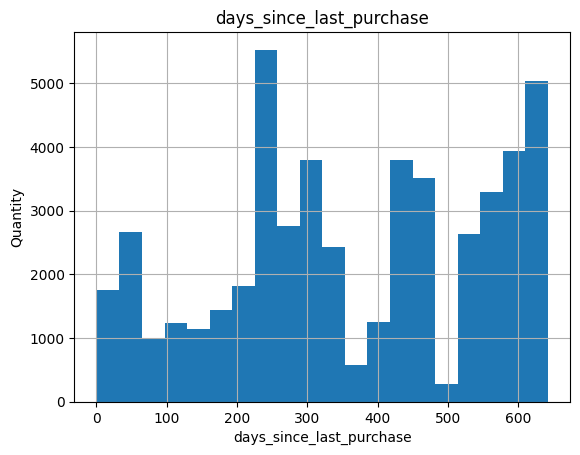

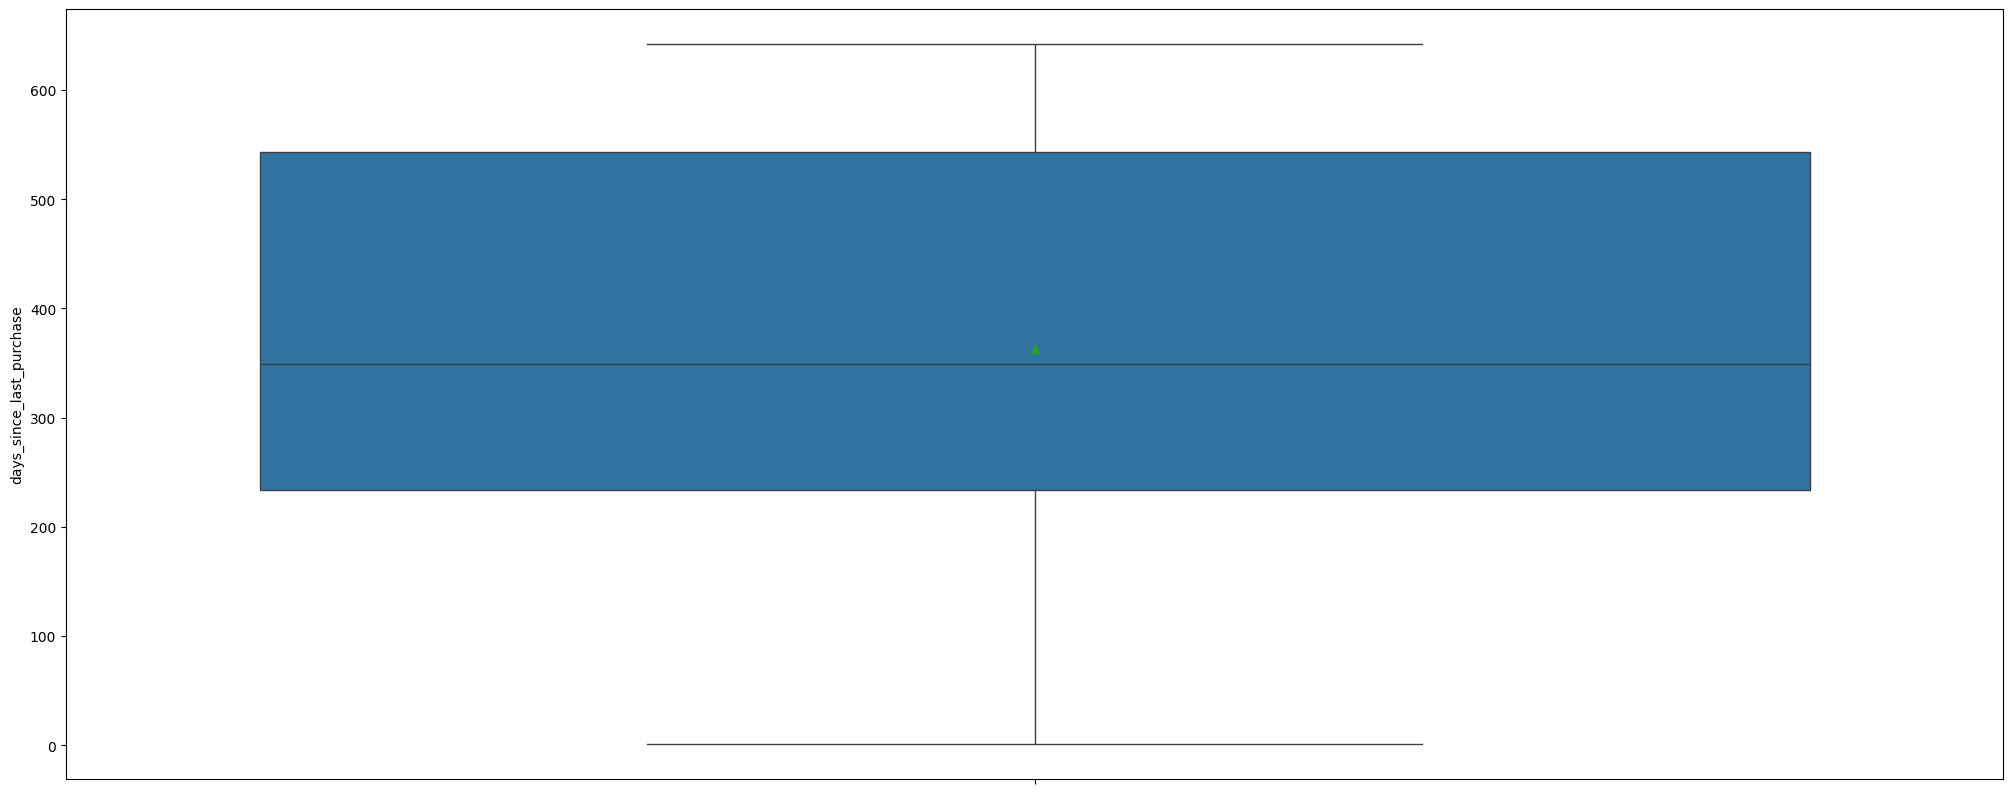

count    49849.000000
mean       362.931593
std        185.301691
min          1.000000
25%        234.000000
50%        349.000000
75%        543.000000
max        642.000000
Name: days_since_last_purchase, dtype: float64


In [49]:
quantitative_feature_plot(df_final, 'days_since_last_purchase')

- *Доля покупок по дням недели*

In [50]:
df_purchases['weekday'] = df_purchases['date'].dt.day_name()
weekday_counts = df_purchases.groupby(['client_id', 'weekday']).size().reset_index(name='count')
total_counts = df_purchases.groupby('client_id').size().reset_index(name='total')
weekday_share = weekday_counts.merge(total_counts, on='client_id')
weekday_share['share'] = weekday_share['count'] / weekday_share['total']
weekday_share = weekday_share.pivot(index='client_id', columns='weekday', values='share').fillna(0)
df_final = df_final.merge(weekday_share, how='left', on='client_id')

- *Доля покупок по годам (2022, 2023, 2024)*

In [51]:
df_purchases['year'] = df_purchases['date'].dt.year
yearly_counts = df_purchases.groupby(['client_id', 'year']).size().reset_index(name='count')
yearly_share = yearly_counts.merge(total_counts, on='client_id')
yearly_share['share'] = yearly_share['count'] / yearly_share['total']
yearly_share = yearly_share.pivot(index='client_id', columns='year', values='share').fillna(0)
df_final = df_final.merge(yearly_share, how='left', on='client_id')
df_final.head()

,client_id,target,total_sum,total_sum_log,total_purchases,total_purchases_log,1,2,3,4,...,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,2022,2023,2024
0,1515915625468060902,0,6993,8.852808,7,2.079442,0.0,0.0,0.0,1.0,...,1.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,1.0,0.0,0.0
1,1515915625468061003,1,16235,9.694986,7,2.079442,0.0,0.0,0.0,1.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,1.000000,0.0,1.0,0.0
2,1515915625468061099,0,299,5.703782,1,0.693147,0.0,0.0,0.0,1.0,...,0.0,0.0,0.000000,0.000000,0.0,1.0,0.000000,1.0,0.0,0.0
3,1515915625468061100,0,2098,7.649216,2,1.098612,0.0,0.0,0.0,1.0,...,0.0,0.0,1.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,1.0
4,1515915625468061170,0,33601,10.422341,19,2.995732,0.0,0.105263,0.0,0.789474,...,0.0,0.0,0.157895,0.210526,0.0,0.0,0.631579,0.0,1.0,0.0


Теперь посмотрим датасет df_messages.

- *Общее количество коммуникаций*

In [52]:
pivot_total_communications = (
    df_messages
      .pivot_table(
          index='client_id',
          values='event',
          aggfunc='count',
          fill_value=0
      )
      .reset_index()
      .rename(columns={'event': 'total_communications'})
)

In [53]:
df_final = df_final.merge(pivot_total_communications, how='left', on='client_id')
df_final.head()

,client_id,target,total_sum,total_sum_log,total_purchases,total_purchases_log,1,2,3,4,...,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,2022,2023,2024,total_communications
0,1515915625468060902,0,6993,8.852808,7,2.079442,0.0,0.0,0.0,1.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,1.0,0.0,0.0,177.0
1,1515915625468061003,1,16235,9.694986,7,2.079442,0.0,0.0,0.0,1.0,...,0.0,0.000000,0.000000,0.0,0.0,1.000000,0.0,1.0,0.0,165.0
2,1515915625468061099,0,299,5.703782,1,0.693147,0.0,0.0,0.0,1.0,...,0.0,0.000000,0.000000,0.0,1.0,0.000000,1.0,0.0,0.0,276.0
3,1515915625468061100,0,2098,7.649216,2,1.098612,0.0,0.0,0.0,1.0,...,0.0,1.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,1.0,428.0
4,1515915625468061170,0,33601,10.422341,19,2.995732,0.0,0.105263,0.0,0.789474,...,0.0,0.157895,0.210526,0.0,0.0,0.631579,0.0,1.0,0.0,293.0


- *Доля приходящаяся на каждый тип отклика на коммуникации*

In [54]:
pivot_communications = df_messages.pivot_table(
    index='client_id',
    columns='event',
    values='date',
    aggfunc='count',
    fill_value=0
).reset_index()
pivot_communications.head()

event,client_id,click,close,complain,hard_bounce,hbq_spam,open,purchase,send,soft_bounce,subscribe,unsubscribe
0,1515915625468060902,10,0,0,0,0,35,5,126,0,0,1
1,1515915625468061003,5,0,0,0,0,5,1,154,0,0,0
2,1515915625468061099,8,0,0,2,0,51,0,215,0,0,0
3,1515915625468061100,1,0,0,1,0,157,1,267,1,0,0
4,1515915625468061170,16,0,0,0,0,31,3,243,0,0,0


In [55]:
df_final = df_final.merge(pivot_communications, how='left', on='client_id')

In [56]:
columns_to_divide = ['click', 'close', 'complain', 'hard_bounce', 'hbq_spam', 'open', 'purchase', 'send', 'soft_bounce', 'subscribe', 'unsubscribe']
df_final[columns_to_divide] = df_final[columns_to_divide].div(df_final['total_communications'], axis=0)
df_final.head()

,client_id,target,total_sum,total_sum_log,total_purchases,total_purchases_log,1,2,3,4,...,close,complain,hard_bounce,hbq_spam,open,purchase,send,soft_bounce,subscribe,unsubscribe
0,1515915625468060902,0,6993,8.852808,7,2.079442,0.0,0.0,0.0,1.0,...,0.0,0.0,0.000000,0.0,0.197740,0.028249,0.711864,0.000000,0.0,0.00565
1,1515915625468061003,1,16235,9.694986,7,2.079442,0.0,0.0,0.0,1.0,...,0.0,0.0,0.000000,0.0,0.030303,0.006061,0.933333,0.000000,0.0,0.00000
2,1515915625468061099,0,299,5.703782,1,0.693147,0.0,0.0,0.0,1.0,...,0.0,0.0,0.007246,0.0,0.184783,0.000000,0.778986,0.000000,0.0,0.00000
3,1515915625468061100,0,2098,7.649216,2,1.098612,0.0,0.0,0.0,1.0,...,0.0,0.0,0.002336,0.0,0.366822,0.002336,0.623832,0.002336,0.0,0.00000
4,1515915625468061170,0,33601,10.422341,19,2.995732,0.0,0.105263,0.0,0.789474,...,0.0,0.0,0.000000,0.0,0.105802,0.010239,0.829352,0.000000,0.0,0.00000


- *Доля приходящаяся на каждый тип канала коммуникации*

In [57]:
pivot_channels = df_messages.pivot_table(
    index='client_id',
    columns='channel',
    values='date',
    aggfunc='count',
    fill_value=0
).reset_index()
pivot_channels.head()

channel,client_id,email,mobile_push
0,1515915625468060902,177,0
1,1515915625468061003,165,0
2,1515915625468061099,182,94
3,1515915625468061100,0,428
4,1515915625468061170,202,91


In [58]:
df_final = df_final.merge(pivot_channels, how='left', on='client_id')

In [59]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 40 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   client_id                 49849 non-null  int64         
 1   target                    49849 non-null  int64         
 2   total_sum                 49849 non-null  Int64         
 3   total_sum_log             49849 non-null  Float64       
 4   total_purchases           49849 non-null  Int64         
 5   total_purchases_log       49849 non-null  Float64       
 6   1                         49848 non-null  Float64       
 7   2                         49848 non-null  Float64       
 8   3                         49848 non-null  Float64       
 9   4                         49848 non-null  Float64       
 10  5                         49848 non-null  Float64       
 11  5562                      49848 non-null  Float64       
 12  5963              

In [60]:
# аналогично разделим, чтобы вычислить доли по каналам коммуникации для каждого клиента
columns_to_divide = ['email', 'mobile_push']
df_final[columns_to_divide] = df_final[columns_to_divide].div(df_final['total_communications'], axis=0)

Видим пропущенные значения в датасете. Посмотрим доли.

In [61]:
df_final.isnull().sum() / df_final.shape[0] * 100.00

client_id                    0.000000
target                       0.000000
total_sum                    0.000000
total_sum_log                0.000000
total_purchases              0.000000
total_purchases_log          0.000000
1                            0.002006
2                            0.002006
3                            0.002006
4                            0.002006
5                            0.002006
5562                         0.002006
5963                         0.002006
6060                         0.002006
last_purchase_date           0.000000
days_since_last_purchase     0.000000
Friday                       0.000000
Monday                       0.000000
Saturday                     0.000000
Sunday                       0.000000
Thursday                     0.000000
Tuesday                      0.000000
Wednesday                    0.000000
2022                         0.000000
2023                         0.000000
2024                         0.000000
total_commun

Заполним медианными значениями.

In [62]:
columns_to_impute = [
    'total_sum', 'total_purchases', '1', '2', '3', '4', '5', '5562', '5963', '6060',
    'total_communications', 'click', 'close', 'complain', 'hard_bounce', 'hbq_spam',
    'open', 'purchase', 'send', 'soft_bounce', 'subscribe', 'unsubscribe', 'email', 'mobile_push'
]

for col in columns_to_impute:
    if col in df_final.columns:
        median_value = df_final[col].median()
        df_final[col].fillna(median_value, inplace=True)

In [63]:
df_final.isnull().sum() / df_final.shape[0] * 100.00

client_id                   0.0
target                      0.0
total_sum                   0.0
total_sum_log               0.0
total_purchases             0.0
total_purchases_log         0.0
1                           0.0
2                           0.0
3                           0.0
4                           0.0
5                           0.0
5562                        0.0
5963                        0.0
6060                        0.0
last_purchase_date          0.0
days_since_last_purchase    0.0
Friday                      0.0
Monday                      0.0
Saturday                    0.0
Sunday                      0.0
Thursday                    0.0
Tuesday                     0.0
Wednesday                   0.0
2022                        0.0
2023                        0.0
2024                        0.0
total_communications        0.0
click                       0.0
close                       0.0
complain                    0.0
hard_bounce                 0.0
hbq_spam

In [64]:
df_final = df_final.drop(['last_purchase_date', 'total_purchases', 'total_sum'], axis=1).reset_index(drop=True)

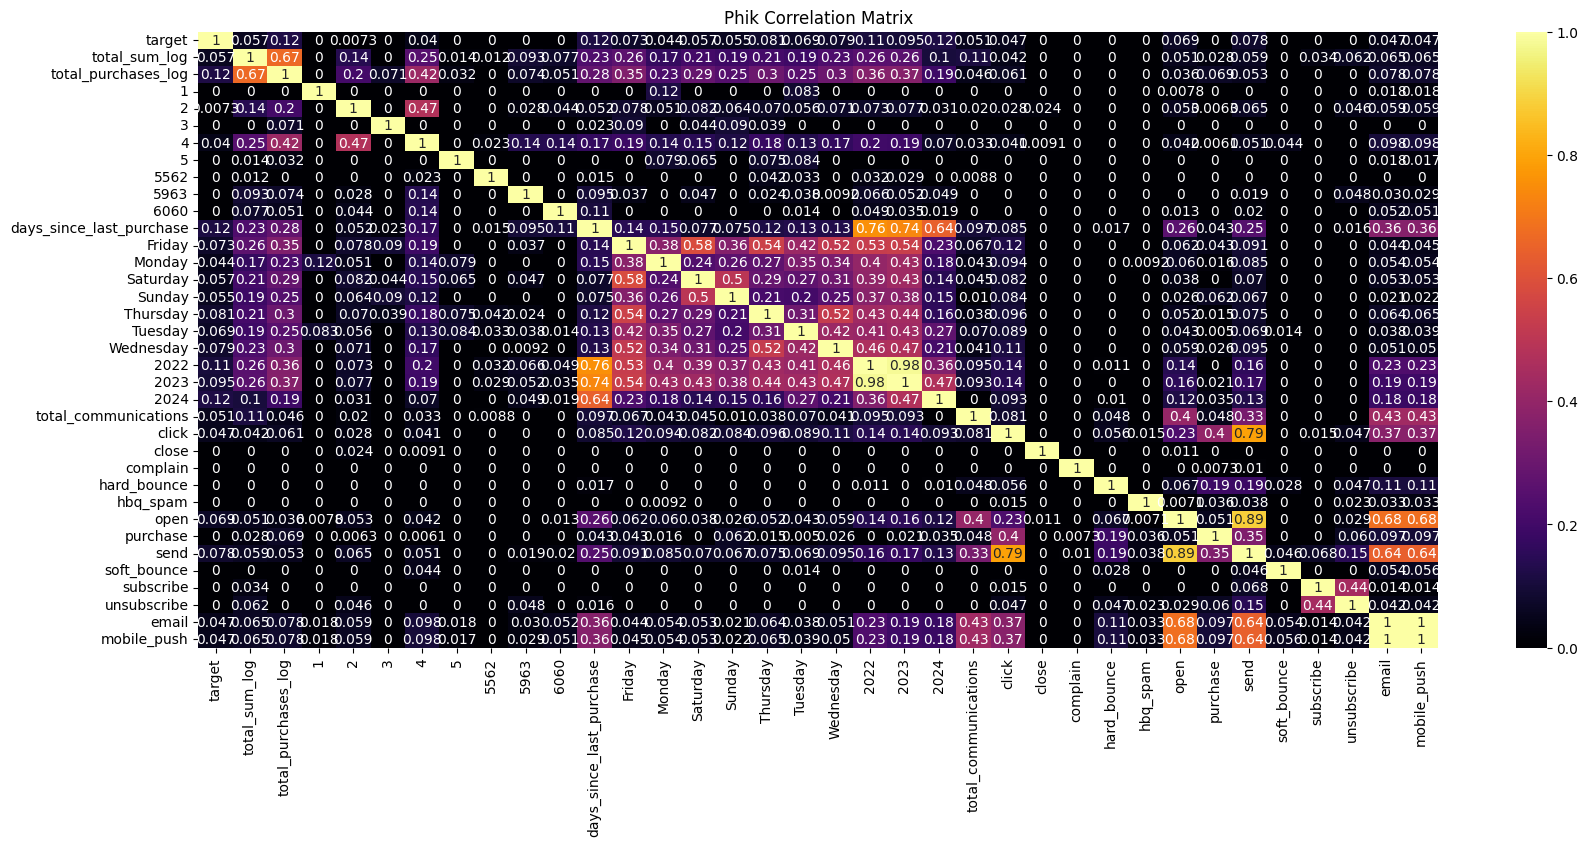

In [65]:
# список интервальных признаков
interval_cols = ['total_sum_log', 'total_purchases_log', '1', '2', '3', '4', '5', '5562', '5963', '6060', 'total_communications', 'click', 'close', 'complain', 'hard_bounce', 'hbq_spam', 'open', 'purchase', 'send', 'soft_bounce', 'subscribe', 'unsubscribe', 'email', 'mobile_push', 'days_since_last_purchase', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', '2022', '2023', '2024']

# вычисление коэффициентов корреляции phi для датафрейма df_final
exclude_columns = ['client_id']
df_filtered = df_final.drop(columns=exclude_columns)
df_filtered.columns = df_filtered.columns.astype(str)
phik_overview = df_filtered.phik_matrix(interval_cols=interval_cols)

plt.figure(figsize=(20, 8))
sns.heatmap(phik_overview, cmap='inferno', annot=True, vmin=0, vmax=1)
plt.title("Phik Correlation Matrix")
plt.show()

Целевой признак слабо коррелирует с выбранными признаками. Удалим send, т.к. он коррелирует с другими признаками. Также видим, что динамические признаки (с распределением по годам) коррелируют с days_since_last_purchase. Удалим их тоже.

In [66]:
df_final = df_final.drop(['send', 'email', 2022, 2023, 2024], axis=1).reset_index(drop=True)

In [67]:
df_final = df_final.set_index('client_id')

In [68]:
df_final.duplicated().sum()

340

In [69]:
df_final = df_final.drop_duplicates()

In [70]:
df_final.duplicated().sum()

0

### Разделение датасета на выборки и масштабирование признаков

In [71]:
X = df_final.drop(columns=['target'], axis=1)
y = df_final['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=TRAIN_SIZE, random_state=RANDOM_STATE)

In [72]:
# создаем список с названиями признаков
num_minmax_columns = [
    '1',
    '2',
    '3',
    '4',
    '5',
    '5562',
    '5963',
    '6060',
    'click',
    'close',
    'complain',
    'hard_bounce',
    'hbq_spam',
    'open',
    'purchase',
    'soft_bounce',
    'subscribe',
    'unsubscribe',
    'mobile_push',
    'days_since_last_purchase',
    'Monday',
    'Tuesday',
    'Wednesday',
    'Thursday',
    'Friday',
    'Saturday',
    'Sunday'
    ]
num_standardization_columns = [
    'total_communications',
    'total_sum_log',
    'total_purchases_log'
    ]

numerical_transformer_minmax = MinMaxScaler()
numerical_transformer_standardization = StandardScaler()

# общий пайплайн для подготовки данных
preprocessor = ColumnTransformer(
    transformers=[
        ('minmax_scaler', numerical_transformer_minmax, num_minmax_columns),
        ('standard_scaler', numerical_transformer_standardization, num_standardization_columns)
    ], 
    remainder='passthrough'
)

## Обучение моделей

### Модель логистической регрессии

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params: {'clf__C': 100, 'clf__penalty': 'l1'}
Train ROC AUC:   0.7354
Train Precision: 0.3333
Train Recall:    0.0026
Test ROC AUC:   0.7129
Test Precision: 0.0000
Test Recall:    0.0000


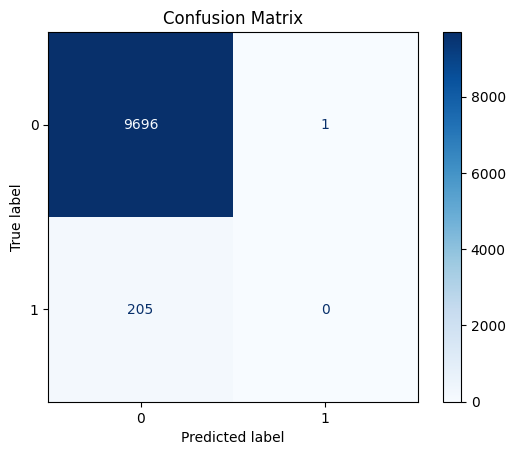

In [74]:
pipeline = Pipeline([
    ('preproc', preprocessor),
    ('clf',     LogisticRegression(solver='liblinear', max_iter=1000, random_state=RANDOM_STATE))
])

# гиперпараметры модели
param_grid = {
    'clf__C':       [0.01, 0.1, 1, 10, 100],
    'clf__penalty': ['l1', 'l2']
}

# т.к. целевая переменная несбалансированная, то применяем k-fold
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=RANDOM_STATE)

# грид сёрч
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=skf,
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
best_model = grid.best_estimator_

# оценка на тренировочной выборке
y_proba_train = best_model.predict_proba(X_train)[:, 1]
y_pred_train  = best_model.predict(X_train)

roc_auc_train   = roc_auc_score(y_train, y_proba_train)
precision_train = precision_score(y_train, y_pred_train)
recall_train    = recall_score(y_train, y_pred_train)

print(f"Train ROC AUC:   {roc_auc_train:.4f}")
print(f"Train Precision: {precision_train:.4f}")
print(f"Train Recall:    {recall_train:.4f}")

# оценка на тестовой выборке
y_proba = best_model.predict_proba(X_test)[:, 1]
y_pred  = best_model.predict(X_test)

roc_auc_test   = roc_auc_score(y_test, y_proba)
precision_test = precision_score(y_test, y_pred)
recall_test    = recall_score(y_test, y_pred)

print(f"Test ROC AUC:   {roc_auc_test:.4f}")
print(f"Test Precision: {precision_test:.4f}")
print(f"Test Recall:    {recall_test:.4f}")

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix")
plt.show()

### Модель дерева решений

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


C:\Users\IskraA\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best params: {'clf__max_depth': 6, 'clf__max_features': 11}
Train ROC AUC:   0.6979
Train Precision: 1.0000
Train Recall:    0.0265
Test ROC AUC:   0.6467
Test Precision: 0.1250
Test Recall:    0.0049


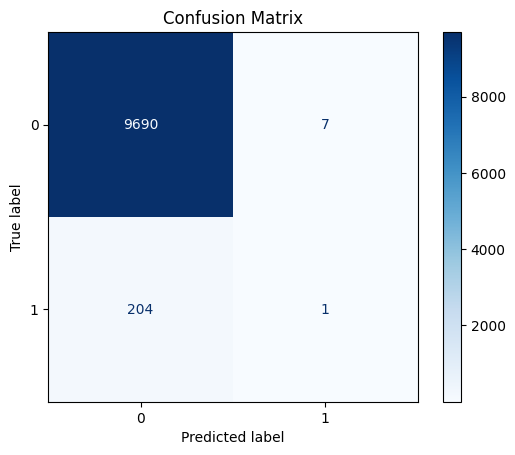

In [75]:
pipeline = Pipeline([
    ('preproc', preprocessor),
    ('clf', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

# гиперпараметры модели
param_grid = {
    'clf__max_depth':     list(range(2, 20)),
    'clf__max_features':  list(range(2, 20))
}

# т.к. целевая переменная несбалансированная, то применяем k-fold
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=RANDOM_STATE)

# грид сёрч
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=skf,
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
best_model = grid.best_estimator_

# оценка на тренировочной выборке
y_proba_train = best_model.predict_proba(X_train)[:, 1]
y_pred_train  = best_model.predict(X_train)

roc_auc_train   = roc_auc_score(y_train, y_proba_train)
precision_train = precision_score(y_train, y_pred_train)
recall_train    = recall_score(y_train, y_pred_train)

print(f"Train ROC AUC:   {roc_auc_train:.4f}")
print(f"Train Precision: {precision_train:.4f}")
print(f"Train Recall:    {recall_train:.4f}")

# оценка на тестовой выборке
y_proba = best_model.predict_proba(X_test)[:, 1]
y_pred  = best_model.predict(X_test)

roc_auc_test   = roc_auc_score(y_test, y_proba)
precision_test = precision_score(y_test, y_pred)
recall_test    = recall_score(y_test, y_pred)

print(f"Test ROC AUC:   {roc_auc_test:.4f}")
print(f"Test Precision: {precision_test:.4f}")
print(f"Test Recall:    {recall_test:.4f}")

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix")
plt.show()

### Модель k ближайших соседей

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best params: {'clf__n_neighbors': 9}


C:\Users\IskraA\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Train ROC AUC:   0.9481
Train Precision: 0.0000
Train Recall:    0.0000
Test ROC AUC:   0.5569
Test Precision: 0.0000
Test Recall:    0.0000


C:\Users\IskraA\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


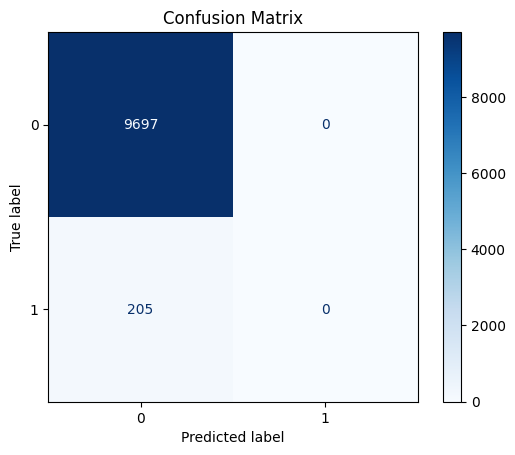

In [76]:
pipeline = Pipeline([
    ('preproc', preprocessor),
    ('clf', KNeighborsClassifier())
])

# гиперпараметры модели
param_grid = {
    'clf__n_neighbors': list(range(2, 10))
}

# т.к. целевая переменная несбалансированная, то применяем k-fold
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=RANDOM_STATE)

# грид сёрч
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=skf,
    verbose=1
)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
best_model = grid.best_estimator_

# оценка на тренировочной выборке
y_proba_train = best_model.predict_proba(X_train)[:, 1]
y_pred_train  = best_model.predict(X_train)

roc_auc_train   = roc_auc_score(y_train, y_proba_train)
precision_train = precision_score(y_train, y_pred_train)
recall_train    = recall_score(y_train, y_pred_train)

print(f"Train ROC AUC:   {roc_auc_train:.4f}")
print(f"Train Precision: {precision_train:.4f}")
print(f"Train Recall:    {recall_train:.4f}")

# оценка на тестовой выборке
y_proba = best_model.predict_proba(X_test)[:, 1]
y_pred  = best_model.predict(X_test)

roc_auc_test   = roc_auc_score(y_test, y_proba)
precision_test = precision_score(y_test, y_pred)
recall_test    = recall_score(y_test, y_pred)

print(f"Test ROC AUC:   {roc_auc_test:.4f}")
print(f"Test Precision: {precision_test:.4f}")
print(f"Test Recall:    {recall_test:.4f}")

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix")
plt.show()

### Метод опорных векторов

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best params: {'clf__kernel': 'linear'}


C:\Users\IskraA\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Train ROC AUC:   0.5997
Train Precision: 0.0000
Train Recall:    0.0000
Test ROC AUC:   0.6023
Test Precision: 0.0000
Test Recall:    0.0000


C:\Users\IskraA\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


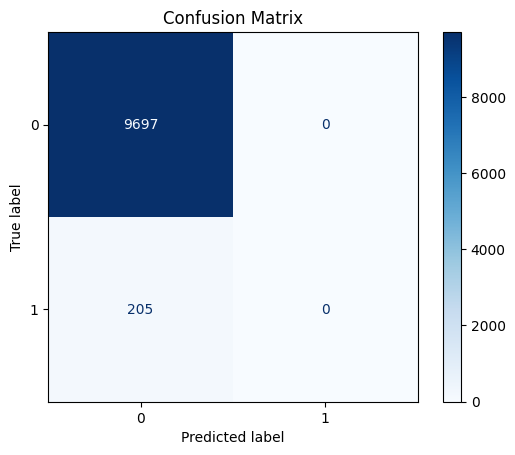

In [77]:
pipeline = Pipeline([
    ('preproc', preprocessor),
    ('clf', SVC(probability=True, random_state=RANDOM_STATE))
])

# гиперпараметры модели
param_grid = {
    'clf__kernel': ['linear', 'rbf']
}

# т.к. целевая переменная несбалансированная, то применяем k-fold
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=RANDOM_STATE)

# грид сёрч
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=skf,
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
best_model = grid.best_estimator_

# оценка на тренировочной выборке
y_proba_train = best_model.predict_proba(X_train)[:, 1]
y_pred_train  = best_model.predict(X_train)

roc_auc_train   = roc_auc_score(y_train, y_proba_train)
precision_train = precision_score(y_train, y_pred_train)
recall_train    = recall_score(y_train, y_pred_train)

print(f"Train ROC AUC:   {roc_auc_train:.4f}")
print(f"Train Precision: {precision_train:.4f}")
print(f"Train Recall:    {recall_train:.4f}")

# оценка на тестовой выборке
y_proba = best_model.predict_proba(X_test)[:, 1]
y_pred  = best_model.predict(X_test)

roc_auc_test   = roc_auc_score(y_test, y_proba)
precision_test = precision_score(y_test, y_pred)
recall_test    = recall_score(y_test, y_pred)

print(f"Test ROC AUC:   {roc_auc_test:.4f}")
print(f"Test Precision: {precision_test:.4f}")
print(f"Test Recall:    {recall_test:.4f}")

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix")
plt.show()

### Модель классификатора LightGBM 

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[LightGBM] [Info] Number of positive: 756, number of negative: 38851
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003408 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3985
[LightGBM] [Info] Number of data points in the train set: 39607, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.019088 -> initscore=-3.939448
[LightGBM] [Info] Start training from score -3.939448
Best params: {'clf__learning_rate': 0.01, 'clf__n_estimators': 200, 'clf__num_leaves': 31}
Train ROC AUC:   0.8864
Train Precision: 1.0000
Train Recall:    0.0066
Test ROC AUC:   0.7350
Test Precision: 0.0000
Test Recall:    0.0000


C:\Users\IskraA\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


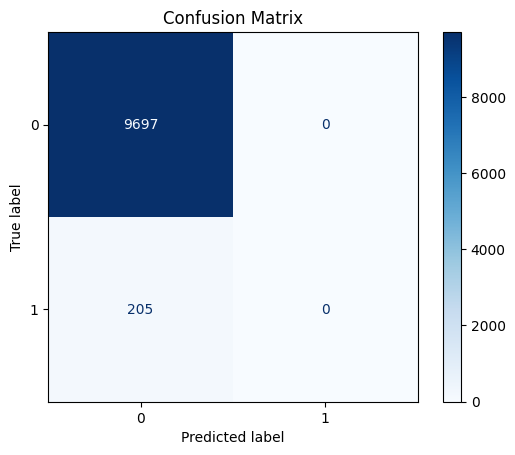

In [78]:
pipeline = Pipeline([
    ('preproc', preprocessor),
    ('clf', LGBMClassifier(random_state=RANDOM_STATE))
])

# гиперпараметры модели
param_grid = {
    'clf__n_estimators':    [100, 200, 500],
    'clf__num_leaves':      [31, 63, 127],
    'clf__learning_rate':   [0.01, 0.05, 0.1]
}

# т.к. целевая переменная несбалансированная, то применяем k-fold
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=RANDOM_STATE)

# грид сёрч
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=skf,
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
best_model = grid.best_estimator_

# оценка на тренировочной выборке
y_proba_train = best_model.predict_proba(X_train)[:, 1]
y_pred_train  = best_model.predict(X_train)

roc_auc_train   = roc_auc_score(y_train, y_proba_train)
precision_train = precision_score(y_train, y_pred_train)
recall_train    = recall_score(y_train, y_pred_train)

print(f"Train ROC AUC:   {roc_auc_train:.4f}")
print(f"Train Precision: {precision_train:.4f}")
print(f"Train Recall:    {recall_train:.4f}")

# оценка на тестовой выборке
y_proba = best_model.predict_proba(X_test)[:, 1]
y_pred  = best_model.predict(X_test)

roc_auc_test   = roc_auc_score(y_test, y_proba)
precision_test = precision_score(y_test, y_pred)
recall_test    = recall_score(y_test, y_pred)

print(f"Test ROC AUC:   {roc_auc_test:.4f}")
print(f"Test Precision: {precision_test:.4f}")
print(f"Test Recall:    {recall_test:.4f}")

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix")
plt.show()

### Модель Catboost

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best params: {'clf__depth': 4, 'clf__iterations': 200, 'clf__l2_leaf_reg': 5, 'clf__learning_rate': 0.1}
Train ROC AUC:   0.8015
Train Precision: 1.0000
Train Recall:    0.0225
Test ROC AUC:   0.7432
Test Precision: 0.3333
Test Recall:    0.0049


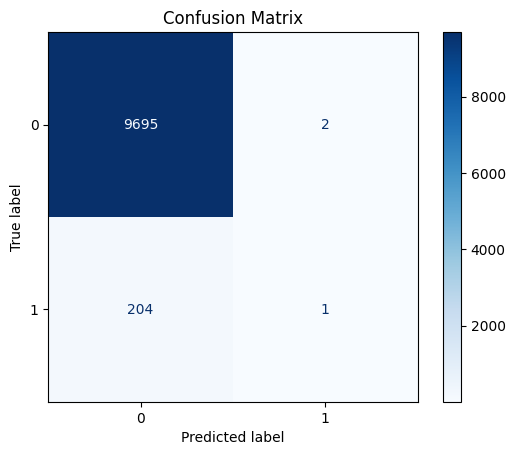

In [79]:
pipeline = Pipeline([
    ('preproc', preprocessor),
    ('clf', CatBoostClassifier(
        random_state=RANDOM_STATE,
        verbose=0,
        allow_writing_files=False,
        thread_count=1))
])

# гиперпараметры модели
param_grid = {
    'clf__iterations':     [100, 200, 500],
    'clf__depth':          [4, 6, 8],
    'clf__learning_rate':  [0.01, 0.1],
    'clf__l2_leaf_reg':    [1, 3, 5]
}

# т.к. целевая переменная несбалансированная, то применяем k-fold
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=RANDOM_STATE)

# грид сёрч
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=skf,
    n_jobs=-1,
    verbose=1,
    error_score='raise'
)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
best_model = grid.best_estimator_

# оценка на тренировочной выборке
y_proba_train = best_model.predict_proba(X_train)[:, 1]
y_pred_train  = best_model.predict(X_train)

roc_auc_train   = roc_auc_score(y_train, y_proba_train)
precision_train = precision_score(y_train, y_pred_train)
recall_train    = recall_score(y_train, y_pred_train)

print(f"Train ROC AUC:   {roc_auc_train:.4f}")
print(f"Train Precision: {precision_train:.4f}")
print(f"Train Recall:    {recall_train:.4f}")

# оценка на тестовой выборке
y_proba = best_model.predict_proba(X_test)[:, 1]
y_pred  = best_model.predict(X_test)

roc_auc_test   = roc_auc_score(y_test, y_proba)
precision_test = precision_score(y_test, y_pred)
recall_test    = recall_score(y_test, y_pred)

print(f"Test ROC AUC:   {roc_auc_test:.4f}")
print(f"Test Precision: {precision_test:.4f}")
print(f"Test Recall:    {recall_test:.4f}")

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix")
plt.show()

Таким образом, согласно условий поставленных в ТЗ, лучшей моделью является модель Catboost.

### Расчёт самой эффективной модели с максимизацией метрики Precision

С точки зрения бизнеса roc_auc - не самая подходящая метрика. Она показывает насколько эффективно модель работает при разных диапазонах классификации. В нашем же случае можно предложить другую метрику - Precision, которая показывает какая доля покупателей из всех предсказанных действительно что-то купит. Попробуем максимизировать эту метрику модели Catboost.

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best params: {'clf__depth': 8, 'clf__iterations': 500, 'clf__l2_leaf_reg': 3, 'clf__learning_rate': 0.1}
Train ROC AUC:   0.9819
Train Precision: 1.0000
Train Recall:    0.4299
Test ROC AUC:   0.7142
Test Precision: 0.5000
Test Recall:    0.0049


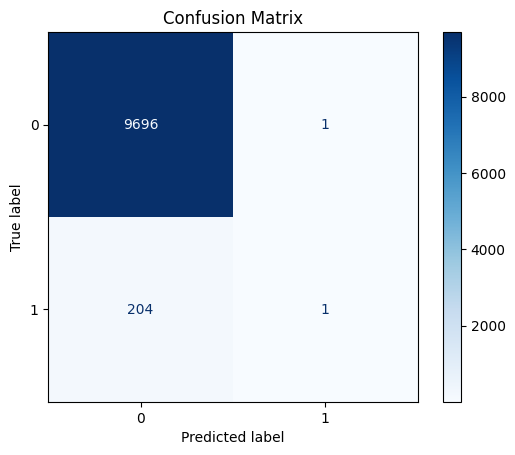

In [80]:
pipeline = Pipeline([
    ('preproc', preprocessor),
    ('clf', CatBoostClassifier(
        random_state=RANDOM_STATE,
        verbose=0,
        allow_writing_files=False,
        thread_count=1))
])

# гиперпараметры модели
param_grid = {
    'clf__iterations':     [100, 200, 500],
    'clf__depth':          [4, 6, 8],
    'clf__learning_rate':  [0.01, 0.1],
    'clf__l2_leaf_reg':    [1, 3, 5]
}

# т.к. целевая переменная несбалансированная, то применяем k-fold
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=RANDOM_STATE)

# грид сёрч
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='precision',
    cv=skf,
    n_jobs=-1,
    verbose=1,
    error_score='raise'
)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
best_model = grid.best_estimator_

# оценка на тренировочной выборке
y_proba_train = best_model.predict_proba(X_train)[:, 1]
y_pred_train  = best_model.predict(X_train)

roc_auc_train   = roc_auc_score(y_train, y_proba_train)
precision_train = precision_score(y_train, y_pred_train)
recall_train    = recall_score(y_train, y_pred_train)

print(f"Train ROC AUC:   {roc_auc_train:.4f}")
print(f"Train Precision: {precision_train:.4f}")
print(f"Train Recall:    {recall_train:.4f}")

# оценка на тестовой выборке
y_proba = best_model.predict_proba(X_test)[:, 1]
y_pred  = best_model.predict(X_test)

roc_auc_test   = roc_auc_score(y_test, y_proba)
precision_test = precision_score(y_test, y_pred)
recall_test    = recall_score(y_test, y_pred)

print(f"Test ROC AUC:   {roc_auc_test:.4f}")
print(f"Test Precision: {precision_test:.4f}")
print(f"Test Recall:    {recall_test:.4f}")

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix")
plt.show()

## Выводы

В ТЗ в качестве целевой метрики была поставлена задача максимизировать метрику roc_auc для задачи бинарной классификации купил что-то клиент или нет в течение указанного срока. C этой задачей лучше всех справилась модель Catboost: на тренировочной выборке - 0.8, на тестовой - 0.74 с гиперпараметрами 'clf__depth': 4, 'clf__iterations': 200, 'clf__l2_leaf_reg': 5, 'clf__learning_rate': 0.1.

Однако с точки зрения бизнеса целесообразнее в данном случае было бы установить метрику Precision, которая бы показывала какая доля предсказанных покупателей всё таки купила что-то. Дополнительно были подобраны гиперпараметры модель Catboost c максимизацией метрики Precision - 'clf__depth': 8, 'clf__iterations': 500, 'clf__l2_leaf_reg': 3, 'clf__learning_rate': 0.1. На тестовой выборке удалось достичь показателя в 0.5.